In [1]:
import numpy as np
import pandas as pd
import os
import random
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score,  make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import VotingRegressor, RandomForestClassifier, VotingClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from scipy.optimize import minimize, minimize_scalar
from scipy import stats
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from colorama import Fore, Style
from IPython.display import clear_output
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [2]:
# If using CUDA (GPU)
torch.cuda.is_available()

False

In [3]:
# Create output folders
output_folder = 'output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Create separate analysis output folders
analysis_output_folder = 'analysis_output'
os.makedirs(analysis_output_folder, exist_ok=True)

physical_analysis_output_folder = 'analysis_output/physical'
os.makedirs(physical_analysis_output_folder, exist_ok=True)

fitness_analysis_output_folder = 'analysis_output/fitness'
os.makedirs(fitness_analysis_output_folder, exist_ok=True)

bia_analysis_output_folder = 'analysis_output/bia'
os.makedirs(bia_analysis_output_folder, exist_ok=True)

child_info_analysis_output_folder = 'analysis_output/child_info'
os.makedirs(child_info_analysis_output_folder, exist_ok=True)

actigraphy_analysis_output_folder = 'analysis_output/actigraphy'
os.makedirs(actigraphy_analysis_output_folder, exist_ok=True)

# Set display all columns in dataframes property
pd.options.display.max_columns = None

# Supress warnings
warnings.filterwarnings('ignore')

In [4]:
# Model classes
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(out_features, out_features),
            nn.BatchNorm1d(out_features)
        )
        
        self.skip = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features)
        ) if in_features != out_features else nn.Identity()
        
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        return self.activation(self.block(x) + self.skip(x))

class AdvancedAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=32, dropout_rate=0.2):
        super(AdvancedAutoencoder, self).__init__()
        
        # Encoder with residual connections and batch normalization
        self.encoder = nn.Sequential(
            # Input layer
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            
            # First residual block
            ResidualBlock(128, 96),
            
            # Second residual block
            ResidualBlock(96, 64),
            
            # Bottleneck layers with variational component
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            
            # Mean and log variance for variational component
            nn.Linear(32, latent_dim * 2)
        )
        
        # Decoder with transpose of encoder architecture
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            
            # Expanding layers
            ResidualBlock(32, 64),
            ResidualBlock(64, 96),
            
            # Output layer
            nn.Linear(96, input_dim),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        # Encode
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        
        # Reparameterize
        z = self.reparameterize(mu, log_var)
        
        # Decode
        reconstructed = self.decoder(z)
        
        return reconstructed, mu, log_var, z

In [5]:
# Helper functions
def train_model(model, train_loader, val_loader, epochs=150, learning_rate=0.001, beta=0.05, device='cuda'):
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    reconstruction_criterion = nn.MSELoss()
    best_val_loss = float('inf')
    best_model = None
    
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in tqdm(range(epochs), desc="Training"):
        # Training phase
        model.train()
        train_loss = 0
        for batch in train_loader:
            x = batch[0].to(device)
            
            # Forward pass
            reconstructed, mu, log_var, z = model(x)
            
            # Calculate losses
            recon_loss = reconstruction_criterion(reconstructed, x)
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            total_loss = recon_loss + beta * kl_loss
            
            # Backward pass
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            train_loss += total_loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0].to(device)
                reconstructed, mu, log_var, z = model(x)
                
                recon_loss = reconstruction_criterion(reconstructed, x)
                kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
                total_loss = recon_loss + beta * kl_loss
                val_loss += total_loss.item()
        
        # Update learning rate
        scheduler.step()
        
        # Record losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict().copy()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    # Load best model
    model.load_state_dict(best_model)
    return model, history

def encode_data(model, data, scaler, device='cuda'):
    model.eval()
    scaled_data = scaler.transform(data)
    data_tensor = torch.FloatTensor(scaled_data).to(device)
    
    with torch.no_grad():
        _, mu, _, z = model(data_tensor)
    
    return mu.cpu().numpy(), z.cpu().numpy()

def decode_data(model, latent_vectors, scaler, device='cuda'):
    model.eval()
    latent_tensor = torch.FloatTensor(latent_vectors).to(device)
    
    with torch.no_grad():
        reconstructed = model.decoder(latent_tensor)
    
    return scaler.inverse_transform(reconstructed.cpu().numpy())

In [6]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

In [7]:
def train_timeseries_autoencoder(df_train, df_test, verbose=True):
    """Train autoencoder on time series statistics"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if verbose:
        print(f"Using device: {device}")

    # Initialize model
    input_dim = df_train.shape[1]
    model = AdvancedAutoencoder(input_dim=input_dim, latent_dim=32, dropout_rate=0.2)
    
    # Prepare data
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(df_train)
    test_scaled = scaler.transform(df_test)
    
    # Convert to tensors
    train_tensor = torch.FloatTensor(train_scaled)
    test_tensor = torch.FloatTensor(test_scaled)
    
    # Create data loaders
    train_loader = DataLoader(TensorDataset(train_tensor), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(test_tensor), batch_size=64)
    
    # Train model
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=150,
        learning_rate=0.001,
        beta=0.05,
        device=device
    )
    
    # Generate encodings
    train_mu, train_z = encode_data(model, df_train, scaler, device)
    test_mu, test_z = encode_data(model, df_test, scaler, device)
    
    # Create DataFrames with encoded features
    train_encoded = pd.DataFrame(
        train_z,
        columns=[f'ae_feature_{i}' for i in range(train_z.shape[1])]
    )
    test_encoded = pd.DataFrame(
        test_z,
        columns=[f'ae_feature_{i}' for i in range(test_z.shape[1])]
    )
    
    # Calculate reconstruction error
    train_reconstructed = decode_data(model, train_z, scaler, device)
    test_reconstructed = decode_data(model, test_z, scaler, device)
    
    train_mse = np.mean((df_train.values - train_reconstructed) ** 2, axis=1)
    test_mse = np.mean((df_test.values - test_reconstructed) ** 2, axis=1)
    
    train_encoded['reconstruction_error'] = train_mse
    test_encoded['reconstruction_error'] = test_mse
    
    if verbose:
        # Plot training history
        plt.figure(figsize=(12, 6))
        plt.plot(history['train_loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Autoencoder Training History')
        plt.legend()
        plt.show()
        
        # Plot reconstruction error distribution
        plt.figure(figsize=(12, 6))
        plt.hist(train_mse, bins=50, alpha=0.5, label='Train')
        plt.hist(test_mse, bins=50, alpha=0.5, label='Test')
        plt.xlabel('Reconstruction Error')
        plt.ylabel('Count')
        plt.title('Reconstruction Error Distribution')
        plt.legend()
        plt.show()
        
        # Plot feature importance
        corr = np.corrcoef(train_z.T)[0]
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(corr)), np.abs(corr))
        plt.xlabel('Latent Dimension')
        plt.ylabel('Absolute Correlation with First Component')
        plt.title('Latent Space Feature Importance')
        plt.show()
    
    return model, train_encoded, test_encoded, scaler

In [8]:
# Load data
print("Loading data...")
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

print("Loading time series data...")
train_ts = load_time_series("input/series_train.parquet")
test_ts = load_time_series("input/series_test.parquet")

print("Preparing features...")
df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

Loading data...
Loading time series data...


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]

Preparing features...


Training autoencoder...
Using device: cpu


Training:   7%|▋         | 10/150 [00:01<00:25,  5.45it/s]

Epoch [10/150], Train Loss: 1.0573, Val Loss: 0.9520


Training:  13%|█▎        | 20/150 [00:03<00:24,  5.40it/s]

Epoch [20/150], Train Loss: 1.0041, Val Loss: 0.9527


Training:  21%|██        | 31/150 [00:05<00:21,  5.58it/s]

Epoch [30/150], Train Loss: 0.9883, Val Loss: 0.9470


Training:  27%|██▋       | 41/150 [00:07<00:18,  5.76it/s]

Epoch [40/150], Train Loss: 0.9935, Val Loss: 0.9454


Training:  34%|███▍      | 51/150 [00:09<00:17,  5.62it/s]

Epoch [50/150], Train Loss: 0.9895, Val Loss: 0.9448


Training:  40%|████      | 60/150 [00:10<00:15,  5.70it/s]

Epoch [60/150], Train Loss: 0.9959, Val Loss: 0.9464


Training:  47%|████▋     | 70/150 [00:12<00:14,  5.65it/s]

Epoch [70/150], Train Loss: 0.9824, Val Loss: 0.9457


Training:  53%|█████▎    | 80/150 [00:14<00:12,  5.74it/s]

Epoch [80/150], Train Loss: 0.9838, Val Loss: 0.9455


Training:  61%|██████    | 91/150 [00:16<00:10,  5.70it/s]

Epoch [90/150], Train Loss: 0.9832, Val Loss: 0.9465


Training:  67%|██████▋   | 101/150 [00:17<00:08,  5.64it/s]

Epoch [100/150], Train Loss: 0.9857, Val Loss: 0.9446


Training:  73%|███████▎  | 110/150 [00:19<00:07,  5.70it/s]

Epoch [110/150], Train Loss: 0.9750, Val Loss: 0.9468


Training:  81%|████████  | 121/150 [00:21<00:04,  5.88it/s]

Epoch [120/150], Train Loss: 0.9759, Val Loss: 0.9464


Training:  87%|████████▋ | 131/150 [00:23<00:03,  5.86it/s]

Epoch [130/150], Train Loss: 0.9774, Val Loss: 0.9457


Training:  94%|█████████▍| 141/150 [00:24<00:01,  5.85it/s]

Epoch [140/150], Train Loss: 0.9836, Val Loss: 0.9452


Training: 100%|██████████| 150/150 [00:26<00:00,  5.68it/s]


Epoch [150/150], Train Loss: 0.9801, Val Loss: 0.9500


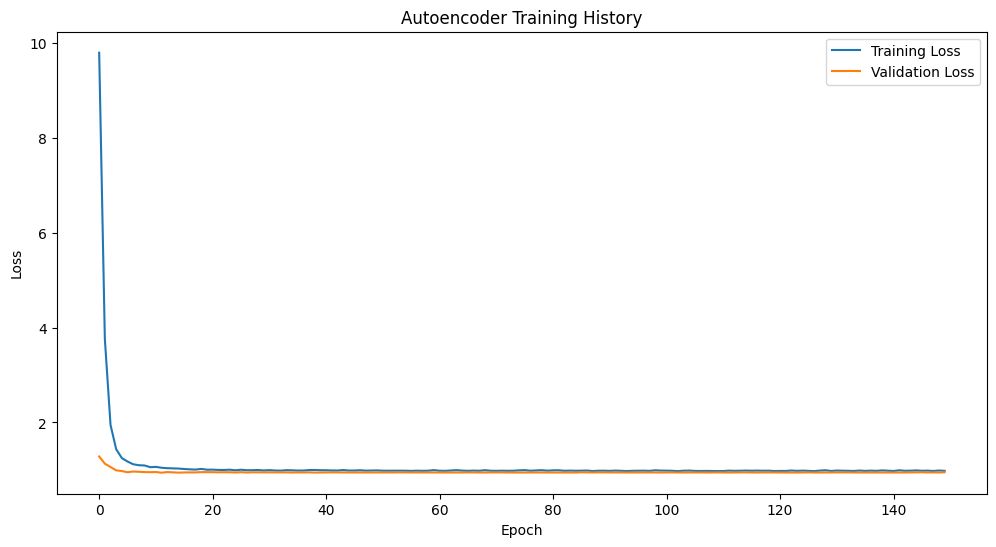

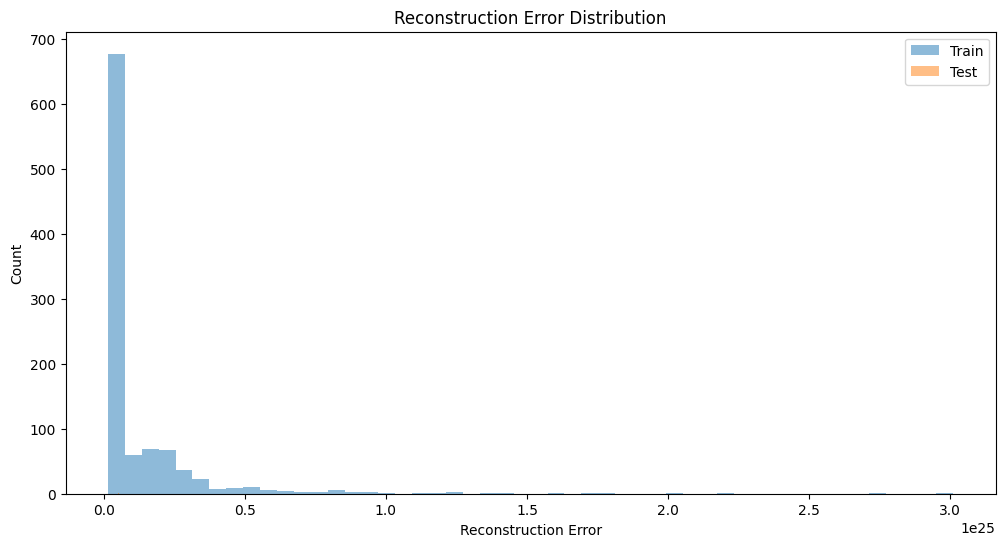

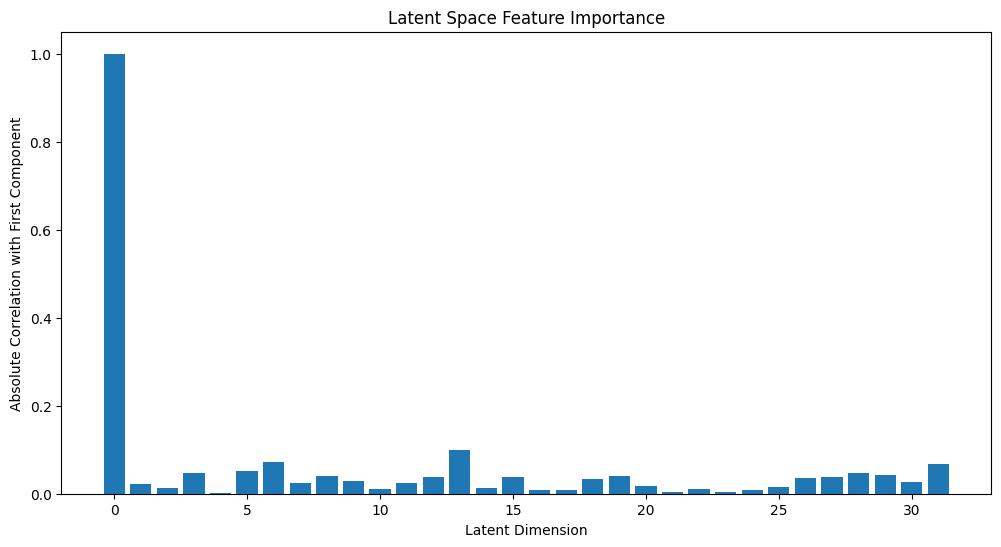

Adding encoded features...

Train shape after encoding: (996, 130)
Test shape after encoding: (2, 130)
Done!


In [9]:
# Train autoencoder
print("Training autoencoder...")
model, train_encoded, test_encoded, scaler = train_timeseries_autoencoder(
    df_train, 
    df_test,
    verbose=True
)

# Add encoded features to original dataframes
print("Adding encoded features...")
train_ts_with_features = pd.concat([train_ts, train_encoded], axis=1)
test_ts_with_features = pd.concat([test_ts, test_encoded], axis=1)

print("\nTrain shape after encoding:", train_ts_with_features.shape)
print("Test shape after encoding:", test_ts_with_features.shape)

print("Done!")

Applying Box-Cox transformations...
Processing training data...


100%|██████████| 24/24 [00:00<00:00, 496.51it/s]


Optimal lambda for stat_23: 0.1644
Rows before/after: 996/996
Optimal lambda for stat_35: 0.2975
Rows before/after: 996/996
Optimal lambda for stat_38: 68.4053
Rows before/after: 996/996
Optimal lambda for stat_40: -2.6196
Rows before/after: 996/996
Optimal lambda for stat_47: 0.1592
Rows before/after: 996/996
Optimal lambda for stat_54: -0.3639
Rows before/after: 996/996
Optimal lambda for stat_66: 0.0516
Rows before/after: 996/996
Optimal lambda for stat_78: 0.0902
Rows before/after: 996/996
Optimal lambda for stat_80: 2.3224
Rows before/after: 996/996
Optimal lambda for stat_88: 53.2662
Rows before/after: 996/996
Optimal lambda for stat_90: 0.8219
Rows before/after: 996/996

Processing test data...


100%|██████████| 24/24 [00:00<00:00, 2999.95it/s]

Applied lambda 0.1644 to stat_23
Rows before/after: 2/2
Applied lambda 0.2975 to stat_35
Rows before/after: 2/2
Applied lambda 68.4053 to stat_38
Rows before/after: 2/2
Applied lambda -2.6196 to stat_40
Rows before/after: 2/2
Applied lambda 0.1592 to stat_47
Rows before/after: 2/2
Applied lambda -0.3639 to stat_54
Rows before/after: 2/2
Applied lambda 0.0516 to stat_66
Rows before/after: 2/2
Applied lambda 0.0902 to stat_78
Rows before/after: 2/2
Applied lambda 2.3224 to stat_80
Rows before/after: 2/2
Applied lambda 53.2662 to stat_88
Rows before/after: 2/2
Applied lambda 0.8219 to stat_90
Rows before/after: 2/2

Successfully transformed 11 columns

Plotting transformations...


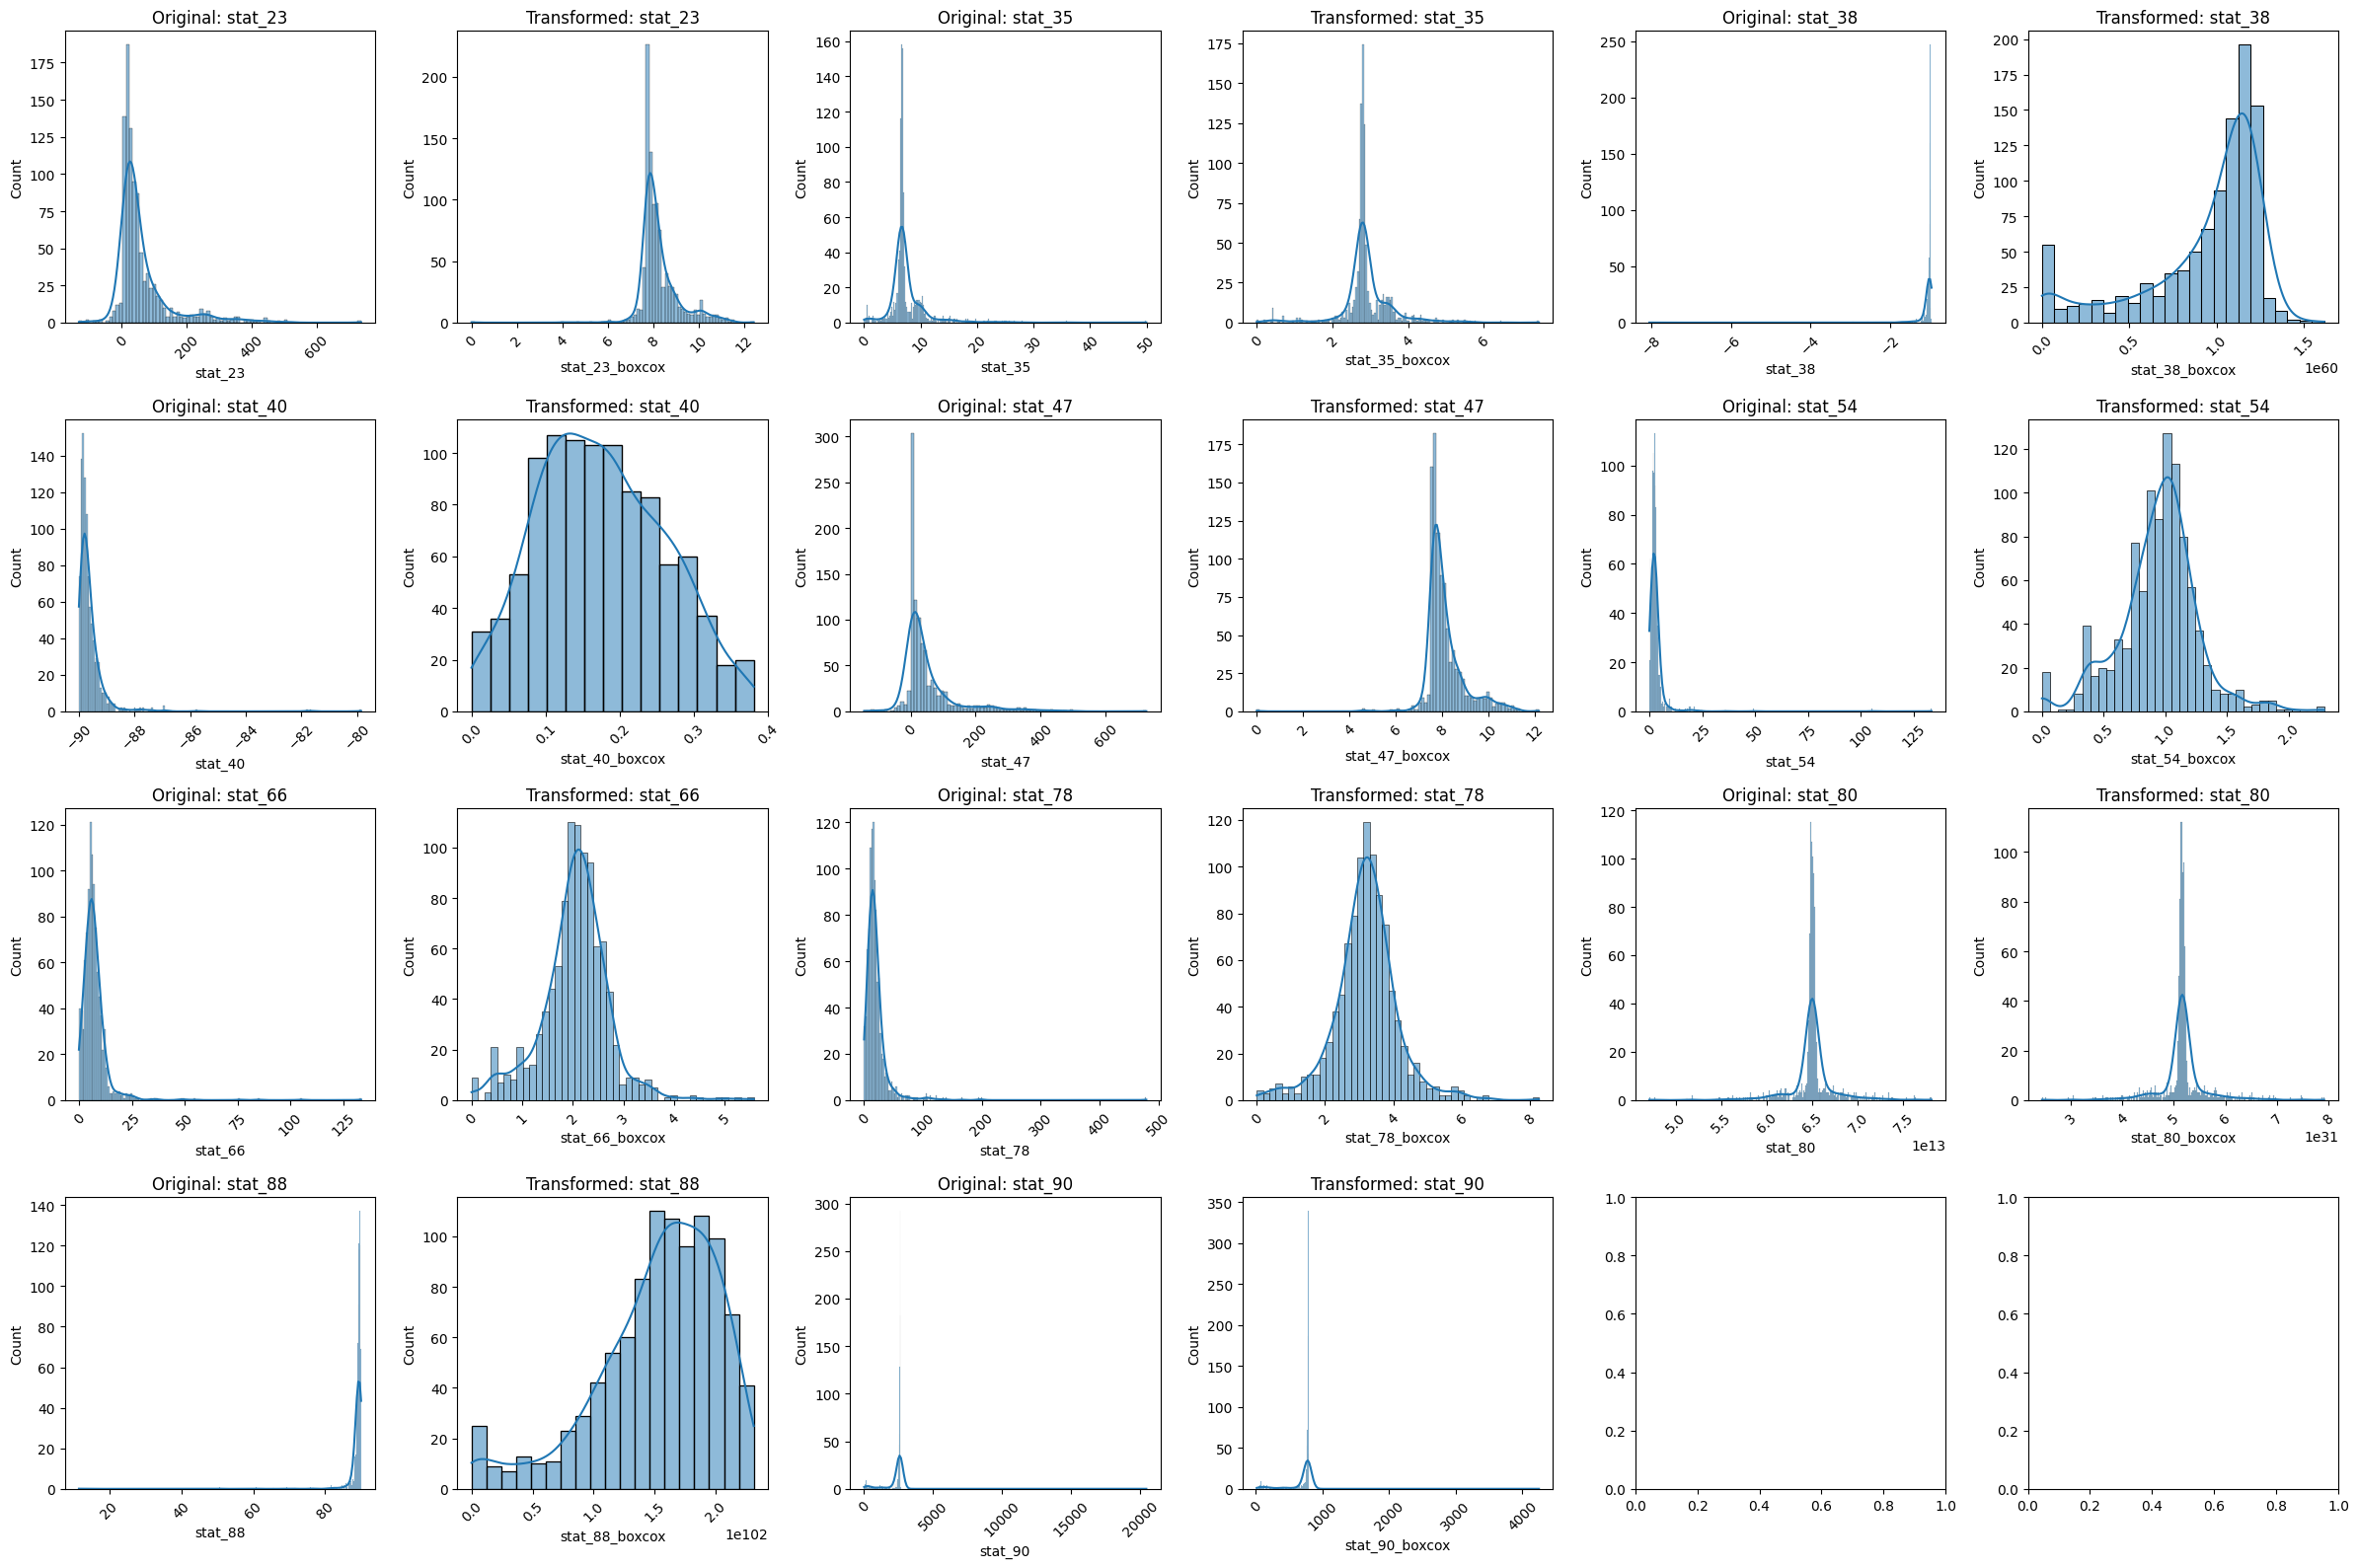


Data preprocessing complete!


In [10]:
# Skew removal for specified columns
skewed_columns = [
    'BIA-BIA_BMC', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_Fat',
    'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 
    'BIA-BIA_TBW', 'CGAS-CGAS_Score', 'stat_23', 'stat_35', 'stat_38', 'stat_40', 'stat_47',
    'stat_54', 'stat_66', 'stat_78', 'stat_80', 'stat_88', 'stat_90'
]

def box_cox_transform(df, column, lambda_param=None, verbose=True):
    """Apply Box-Cox transformation to a column"""
    df_copy = df.copy()
    df_copy = df_copy.dropna(subset=[column])
    
    # Ensure all values are positive
    min_value = df_copy[column].min()
    if min_value <= 0:
        df_copy[column] = df_copy[column] - min_value + 1
    
    try:
        if lambda_param is None:
            transformed_values, lambda_param = stats.boxcox(df_copy[column])
            if verbose:
                print(f"Optimal lambda for {column}: {lambda_param:.4f}")
        else:
            transformed_values = stats.boxcox(df_copy[column], lmbda=lambda_param)
            if verbose:
                print(f"Applied lambda {lambda_param:.4f} to {column}")
        
        df_copy[f'{column}_boxcox'] = transformed_values
        
        if verbose:
            print(f"Rows before/after: {len(df)}/{len(df_copy)}")
            
        return df_copy, lambda_param
    
    except Exception as e:
        print(f"Error transforming {column}: {str(e)}")
        return df_copy, None

def replace_inf_with_max(df):
    """Replace infinite values with maximum non-infinite value"""
    df_copy = df.copy()
    for column in df_copy.columns:
        if df_copy[column].dtype == 'float64':
            mask = ~np.isinf(df_copy[column])
            if mask.any():
                max_value = df_copy.loc[mask, column].max()
                df_copy[column] = df_copy[column].replace([np.inf, -np.inf], max_value)
    return df_copy

def process_skewed_columns(train_df, test_df, skewed_columns, verbose=True):
    """Process skewed columns in both train and test data"""
    lambda_params = {}
    train_processed = train_df.copy()
    test_processed = test_df.copy()
    
    # Process training data and store lambda values
    print("Processing training data...")
    for column in tqdm(skewed_columns):
        if column in train_df.columns:
            transformed_train, lambda_params[column] = box_cox_transform(
                train_df, 
                column, 
                verbose=verbose
            )
            if lambda_params[column] is not None:
                train_processed[f'{column}_boxcox'] = transformed_train[f'{column}_boxcox']
    
    # Process test data using stored lambda values
    print("\nProcessing test data...")
    for column in tqdm(skewed_columns):
        if column in test_df.columns and column in lambda_params:
            transformed_test, _ = box_cox_transform(
                test_df, 
                column, 
                lambda_param=lambda_params[column],
                verbose=verbose
            )
            if lambda_params[column] is not None:
                test_processed[f'{column}_boxcox'] = transformed_test[f'{column}_boxcox']
    
    # Handle infinite values
    train_processed = replace_inf_with_max(train_processed)
    test_processed = replace_inf_with_max(test_processed)
    
    # Get list of successfully transformed columns
    transformed_columns = [f'{col}_boxcox' for col in skewed_columns 
                         if f'{col}_boxcox' in train_processed.columns]
    
    if verbose:
        print(f"\nSuccessfully transformed {len(transformed_columns)} columns")
        
    return train_processed, test_processed, lambda_params, transformed_columns

# Function to visualize transformations
def plot_transformations(df_before, df_after, columns, n_cols=3, max_rows=5):
    """Plot histograms before and after transformation"""
    n_cols = min(n_cols, len(columns))
    n_rows = min(max_rows, (len(columns) + n_cols - 1) // n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=(n_cols * 8, n_rows * 4))
    axes = axes.ravel()
    
    for i, column in enumerate(columns[:n_rows * n_cols]):
        # Original distribution
        sns.histplot(df_before[column], ax=axes[i*2], kde=True)
        axes[i*2].set_title(f'Original: {column}')
        axes[i*2].tick_params(axis='x', rotation=45)
        
        # Transformed distribution
        sns.histplot(df_after[f'{column}_boxcox'], ax=axes[i*2+1], kde=True)
        axes[i*2+1].set_title(f'Transformed: {column}')
        axes[i*2+1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Apply transformations
print("Applying Box-Cox transformations...")
train_processed, test_processed, lambda_params, transformed_cols = process_skewed_columns(
    df_train, 
    df_test, 
    skewed_columns,
    verbose=True
)

# Visualize some transformations
print("\nPlotting transformations...")
plot_transformations(df_train, train_processed, 
                    [col for col in skewed_columns if f'{col}_boxcox' in transformed_cols])

# Update training data for autoencoder
df_train = train_processed
df_test = test_processed

print("\nData preprocessing complete!")

In [11]:
# Ensure IDs are properly formatted
train_ts_with_features['id'] = train_ts_with_features['id'].astype(str)
test_ts_with_features['id'] = test_ts_with_features['id'].astype(str)
train['id'] = train['id'].astype(str)
test['id'] = test['id'].astype(str)

# Get lists of our different feature types
encoded_cols = [col for col in train_ts_with_features.columns if 'ae_feature_' in col]
boxcox_cols = [col for col in train_processed.columns if '_boxcox' in col]
stats_cols = [col for col in train_processed.columns if col not in boxcox_cols + ['id']]  # Keep original stats

# Create DataFrame with all features: original stats, box-cox transformations, and encoded features
train_all_features = pd.concat([
    train_ts_with_features[['id'] + encoded_cols],  # Encoded features
    train_processed[boxcox_cols],                   # Box-cox transformations
    train_processed[stats_cols]                     # Original stats
], axis=1)

test_all_features = pd.concat([
    test_ts_with_features[['id'] + encoded_cols],   # Encoded features
    test_processed[boxcox_cols],                    # Box-cox transformations
    test_processed[stats_cols]                      # Original stats
], axis=1)

# Merge everything with original dataframes
print("Merging all features with original data...")
train_final = train.merge(
    train_all_features,
    on='id',
    how='left',
    validate='1:1'
)

test_final = test.merge(
    test_all_features,
    on='id',
    how='left',
    validate='1:1'
)

# Verify the merges and feature presence
print("\nShape Check:")
print(f"Original train shape: {train.shape}")
print(f"Train with all features shape: {train_final.shape}")
print(f"Original test shape: {test.shape}")
print(f"Test with all features shape: {test_final.shape}")

# Verify feature counts
print("\nFeature Counts:")
print(f"Number of original stats: {len(stats_cols)}")
print(f"Number of encoded features: {len(encoded_cols)}")
print(f"Number of box-cox transformed features: {len(boxcox_cols)}")
print(f"Total features: {len(stats_cols) + len(encoded_cols) + len(boxcox_cols)}")

# Check that all types of features are present
print("\nSample of feature types in final training data:")
print("\nOriginal stats (first 3):")
print(train_final[stats_cols[:3]].head())
print("\nEncoded features (first 3):")
print(train_final[encoded_cols[:3]].head())
print("\nBox-Cox transformed features (first 3):")
print(train_final[boxcox_cols[:3]].head())

# Check for any missing values after merge
print("\nMissing Values Check:")
print("Train missing values:")
print(train_final.isnull().sum()[train_final.isnull().sum() > 0])
print("\nTest missing values:")
print(test_final.isnull().sum()[test_final.isnull().sum() > 0])

print("\nMerge complete!")

# Print summary of all features
print("\nSummary of features:")
feature_types = {
    'Original Stats': stats_cols,
    'Encoded Features': encoded_cols,
    'Box-Cox Transformed': boxcox_cols
}
for feature_type, features in feature_types.items():
    print(f"\n{feature_type} ({len(features)}):")
    for feat in features[:5]:  # Show first 5 of each type
        print(f"  - {feat}")
    if len(features) > 5:
        print(f"  ... and {len(features)-5} more")

# Optional: Basic feature analysis
print("\nFeature Analysis:")
print("\nMemory usage by feature type:")
for feature_type, features in feature_types.items():
    memory = train_final[features].memory_usage(deep=True).sum() / 1024**2  # Convert to MB
    print(f"{feature_type}: {memory:.2f} MB")

print("\nCorrelation between original and transformed features:")
for original, transformed in zip(skewed_columns[:3], [col for col in boxcox_cols[:3]]):
    if original in train_final.columns:
        corr = train_final[original].corr(train_final[transformed])
        print(f"{original} vs {transformed}: {corr:.3f}")

Merging all features with original data...

Shape Check:
Original train shape: (3960, 82)
Train with all features shape: (3960, 221)
Original test shape: (20, 59)
Test with all features shape: (20, 198)

Feature Counts:
Number of original stats: 96
Number of encoded features: 32
Number of box-cox transformed features: 11
Total features: 139

Sample of feature types in final training data:

Original stats (first 3):
    stat_0   stat_1   stat_2
0      NaN      NaN      NaN
1      NaN      NaN      NaN
2      NaN      NaN      NaN
3  43330.0  43330.0  43330.0
4      NaN      NaN      NaN

Encoded features (first 3):
   ae_feature_0  ae_feature_1  ae_feature_2
0           NaN           NaN           NaN
1           NaN           NaN           NaN
2           NaN           NaN           NaN
3      0.587671     -1.036325      0.608426
4           NaN           NaN           NaN

Box-Cox transformed features (first 3):
   stat_23_boxcox  stat_35_boxcox  stat_38_boxcox
0             NaN      

In [12]:
# Supplement missing data with data from WHO
# Load who data and group
def load_who_bmi_data(file_path):
    who_data = pd.read_csv(file_path)
    who_data = who_data.groupby(['age', 'sex']).agg({
        'L': 'mean', 'mean_bmi': 'mean', 'S': 'mean'
    }).reset_index()
    who_data = who_data.set_index(['sex', 'age'])
    return who_data

def load_who_height_data(file_path):
    who_data = pd.read_csv(file_path)
    who_data = who_data.groupby(['age', 'sex']).agg({
        'mean_height': 'mean'
    }).reset_index()
    who_data = who_data.set_index(['sex', 'age'])
    return who_data

who_bmi_data = load_who_bmi_data('supplemental_data/bmi_for_age_5_to_19.csv')
who_height_data = load_who_height_data('supplemental_data/height_for_age_5_to_19.csv')

In [13]:
# Defining functions to Impute with data from WHO
def get_who_stats(age, sex, data_type='bmi'):
    try:
        if data_type == 'bmi':
            stats = who_bmi_data.loc[(sex, age), ['mean_bmi', 'S']]
            return stats['mean_bmi'], stats['S']
        elif data_type == 'height':
            stats = who_height_data.loc[(sex, age), 'mean_height']
            return stats
    except KeyError:
        return None, None if data_type == 'bmi' else None
    
def impute_bmi(age, sex):
    mean_bmi, sd = get_who_stats(age, sex, 'bmi')
    if mean_bmi is not None and sd is not None:
        imputed_bmi = np.random.normal(mean_bmi, sd)
        return round(imputed_bmi, 8)
    else:
        return None

def impute_height(age, sex):
    mean_height_cm = get_who_stats(age, sex, 'height')
    if mean_height_cm is not None:
        mean_height_inches = mean_height_cm / 2.54  # Convert cm to inches
        return round(mean_height_inches, 2)
    else:
        return None
    
def impute_weight(bmi, height_inches):
    if bmi is not None and height_inches is not None:
        height_meters = height_inches * 0.0254  # Convert inches to meters
        weight_kg = bmi * (height_meters ** 2)
        weight_lbs = weight_kg * 2.20462  # Convert kg to lbs
        return round(weight_lbs, 2)
    else:
        return None

def impute_waist_circumference(weight, height, age, sex):
    if weight is not None and height is not None:
        if sex == '0':
            waist = (weight * 0.5) + (height * 0.2) - (age * 0.1)
        else:
            waist = (weight * 0.4) + (height * 0.3) - (age * 0.1)
        return round(waist, 2)
    else:
        return None

def impute_body_fat(bmi, age, sex):
    if bmi is not None:
        if sex == '0':
            body_fat = (1.20 * bmi) + (0.23 * age) - 16.2
        else:
            body_fat = (1.20 * bmi) + (0.23 * age) - 5.4
        return round(max(body_fat, 0), 2)  # Ensure body fat is not negative
    else:
        return None
    
def impute_sds_total_raw():
    # Based on the distribution in Image 1
    mu, sigma = 40, 12  # Estimated from the graph
    imputed_value = np.random.normal(mu, sigma)
    return round(max(min(imputed_value, 90), 20))  # Clip between 20 and 90

def impute_sds_total_t(sds_total_raw):
    if sds_total_raw is not None:
        # Rough linear transformation based on the relationship between raw and T scores
        t_score = 50 + (sds_total_raw - 40) * (10 / 12)
        return round(max(min(t_score, 100), 40))  # Clip between 40 and 100
    else:
        # If raw score is not available, impute based on the distribution in Image 2
        mu, sigma = 60, 15  # Estimated from the graph
        imputed_value = np.random.normal(mu, sigma)
        return round(max(min(imputed_value, 100), 40))  # Clip between 40 and 100

def impute_sii_function(bmi, waist_circumference, body_fat, sds_total_raw, sds_total_t):
    # Create a simple scoring system
    score = 0
    
    # BMI-based score
    if bmi is not None:
        if bmi < 18.5:
            score += 1
        elif bmi >= 25:
            score += 2
        elif bmi >= 30:
            score += 3
    
    # Waist circumference-based score (using general guidelines)
    if waist_circumference is not None:
        if waist_circumference > 60:  # This is a general threshold, might need adjustment
            score += 1
    
    if sds_total_t is not None:
        if sds_total_t > 80:
            score += 1
        if sds_total_t > 90:
            score += 1
    
    # Map the score to sii values without forcing a 3
    if score <= 2:
        return 0
    else:
        return 1

def apply_imputation(df, impute_sii=True):
    def impute_if_missing(row):
        age = row['Basic_Demos-Age']
        sex = row['Basic_Demos-Sex']
        
        if pd.isna(row['Physical-BMI']) and 5 <= age <= 19:
            row['Physical-BMI'] = impute_bmi(age, sex)
        
        if pd.isna(row['Physical-Height']) and 5 <= age <= 19:
            row['Physical-Height'] = impute_height(age, sex)
        
        if pd.isna(row['Physical-Weight']) and row['Physical-BMI'] is not None and row['Physical-Height'] is not None:
            row['Physical-Weight'] = impute_weight(row['Physical-BMI'], row['Physical-Height'])
        
        if pd.isna(row['Physical-Waist_Circumference']):
            row['Physical-Waist_Circumference'] = impute_waist_circumference(
                row['Physical-Weight'], row['Physical-Height'], age, sex
            )
        
        if pd.isna(row['BIA-BIA_Fat']):
            row['BIA-BIA_Fat'] = impute_body_fat(row['Physical-BMI'], age, sex)

        if pd.isna(row['SDS-SDS_Total_Raw']):
            row['SDS-SDS_Total_Raw'] = impute_sds_total_raw()
        
        if pd.isna(row['SDS-SDS_Total_T']):
            row['SDS-SDS_Total_T'] = impute_sds_total_t(row['SDS-SDS_Total_Raw'])
        
        # Impute sii if it's missing and impute_sii is True
        if impute_sii and pd.isna(row['sii']):
            row['sii'] = impute_sii_function(
                row['Physical-BMI'],
                row['Physical-Waist_Circumference'],
                row['BIA-BIA_Fat'],
                row['SDS-SDS_Total_Raw'],
                row['SDS-SDS_Total_T']
            )
        
        return row
    
    return df.apply(impute_if_missing, axis=1)

In [14]:
# Impute all values including 'sii' for train data
train_final = apply_imputation(train_final, impute_sii=True)

# Impute all values except 'sii' for test data
test_final = apply_imputation(test_final, impute_sii=False)

# Check the results
print("Number of missing values after imputation:")
print("BMI:", train_final['Physical-BMI'].isna().sum())
print("Height:", train_final['Physical-Height'].isna().sum())
print("Weight:", train_final['Physical-Weight'].isna().sum())
print("Waist Circumference:", train_final['Physical-Waist_Circumference'].isna().sum())
print("Body Fat Percentage:", train_final['BIA-BIA_Fat'].isna().sum())
print("SDS Total Raw:", train_final['SDS-SDS_Total_Raw'].isna().sum())
print("SDS Total T:", train_final['SDS-SDS_Total_T'].isna().sum())

print("\nSample of imputed values:")
imputed_sample = train_final[
    (train_final['Physical-BMI'].notnull() | train_final['Physical-Height'].notnull() | 
     train_final['Physical-Weight'].notnull() | train_final['Physical-Waist_Circumference'].notnull() | 
     train_final['BIA-BIA_Fat'].notnull() | train_final['SDS-SDS_Total_Raw'].notnull() | 
     train_final['SDS-SDS_Total_T'].notnull()) &
    ((train_final['Physical-BMI'].notnull() != train_final['Physical-BMI'].notnull().shift()) |
     (train_final['Physical-Height'].notnull() != train_final['Physical-Height'].notnull().shift()) |
     (train_final['Physical-Weight'].notnull() != train_final['Physical-Weight'].notnull().shift()) |
     (train_final['Physical-Waist_Circumference'].notnull() != train_final['Physical-Waist_Circumference'].notnull().shift()) |
     (train_final['BIA-BIA_Fat'].notnull() != train_final['BIA-BIA_Fat'].notnull().shift()) |
     (train_final['SDS-SDS_Total_Raw'].notnull() != train_final['SDS-SDS_Total_Raw'].notnull().shift()) |
     (train_final['SDS-SDS_Total_T'].notnull() != train_final['SDS-SDS_Total_T'].notnull().shift()))
].sample(5)[['Basic_Demos-Age', 'Basic_Demos-Sex', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
              'Physical-Waist_Circumference', 'BIA-BIA_Fat', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']]
print(imputed_sample)

Number of missing values after imputation:
BMI: 21
Height: 21
Weight: 20
Waist Circumference: 21
Body Fat Percentage: 21
SDS Total Raw: 0
SDS Total T: 0

Sample of imputed values:
      Basic_Demos-Age  Basic_Demos-Sex  Physical-BMI  Physical-Height  \
1173               13                0     18.414558            62.74   
1887               20                1           NaN              NaN   
997                22                0           NaN              NaN   
1172               21                1           NaN              NaN   
2153               13                0     20.649384            64.50   

      Physical-Weight  Physical-Waist_Circumference  BIA-BIA_Fat  \
1173            103.1                         58.76      19.6900   
1887              NaN                           NaN          NaN   
997               NaN                           NaN          NaN   
1172              NaN                           NaN          NaN   
2153            122.2                    

In [15]:
# Additional analysis of imputation results
print("\nImputation summary by age:")
age_summary = train_final.groupby('Basic_Demos-Age').agg({
    'Physical-BMI': ['count', 'mean', 'std', 'min', 'max'],
    'Physical-Height': ['count', 'mean', 'std', 'min', 'max'],
    'Physical-Weight': ['count', 'mean', 'std', 'min', 'max'],
    'Basic_Demos-Sex': 'count'
})
print(age_summary)


Imputation summary by age:
                Physical-BMI                                             \
                       count       mean       std        min        max   
Basic_Demos-Age                                                           
5                        112  16.647833  2.712031  12.853139  26.512004   
6                        369  16.232228  2.605239   0.000000  34.055363   
7                        436  16.483782  2.855180   9.693766  43.468833   
8                        490  17.305560  3.605419   0.000000  59.132048   
9                        467  17.510848  3.137561  11.925153  33.729946   
10                       420  18.389130  4.044671   0.000000  44.554097   
11                       334  19.048208  3.976343  11.915254  37.484035   
12                       291  20.115598  4.431546  14.223937  40.399621   
13                       236  20.474761  4.766061   0.000000  39.494148   
14                       200  21.748312  5.145871  13.740613  44.835548 

In [16]:
# Plot of imputed vs. original data
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train_final, x='Basic_Demos-Age', y='Physical-BMI', hue='Basic_Demos-Sex', alpha=0.5)
plt.title('BMI vs Age (After Imputation)')
plt.savefig('analysis_output/bmi_vs_age_imputed.png')
plt.close()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=train_final, x='Basic_Demos-Age', y='Physical-Height', hue='Basic_Demos-Sex', alpha=0.5)
plt.title('Height vs Age (After Imputation)')
plt.savefig('analysis_output/height_vs_age_imputed.png')
plt.close()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=train_final, x='Basic_Demos-Age', y='Physical-Weight', hue='Basic_Demos-Sex', alpha=0.5)
plt.title('Weight vs Age (After Imputation)')
plt.savefig('analysis_output/weight_vs_age_imputed.png')
plt.close()

print("Imputation analysis plots saved in the 'analysis_output' folder.")

Imputation analysis plots saved in the 'analysis_output' folder.


In [17]:
# Feature engineering
def engineer_features(df, is_train=True):
    # Combine all grip strength
    df['FGC-FGC_GS'] = df['FGC-FGC_GSD_Zone'] + df['FGC-FGC_GSND_Zone']
    
    # Combine all sit and reach
    df['FGC-FGC_SR'] = df['FGC-FGC_SRL_Zone'] + df['FGC-FGC_SRR_Zone']
    
    # Create a fitness score by adding the zone fitness data
    df['fitness_score'] = df['FGC-FGC_GS'] + df['FGC-FGC_SR'] + df['FGC-FGC_CU_Zone'] + df['FGC-FGC_PU_Zone'] + df['FGC-FGC_TL_Zone']
    
    # Combine PAQ_A-PAQ_A_Total and PAQ_C-PAQ_C_Total into one column
    df['PAQ_Total'] = df['PAQ_A-PAQ_A_Total'].combine_first(df['PAQ_C-PAQ_C_Total'])
    
    # Reworking of features from other notebook
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['Age_Internet_Hours'] = df['PreInt_EduHx-computerinternet_hoursday'] / df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BIA_BMI_Internet_Hours_Age'] = (df['BIA-BIA_BMI'] * df['PreInt_EduHx-computerinternet_hoursday']) / df['Basic_Demos-Age']
    
    # df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    # df['BFP_BMI_Age'] = df['BIA-BIA_Fat'] / (df['BIA-BIA_BMI']*df['BMI_Age'])
    
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    # df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
   
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['BMR_BMI'] = df['BIA-BIA_BMR'] / df['Physical-BMI']
    df['DEE_BMI'] = df['BIA-BIA_DEE'] / df['Physical-BMI']
    df['SMM_BMI'] = df['BIA-BIA_SMM'] / df['Physical-BMI']
    
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['Physical-Weight'] / df['BIA-BIA_TBW']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    df['Age_Weight'] = df['Basic_Demos-Age'] * df['Physical-Weight']
    df['Age_Weight_BMI'] = (df['Basic_Demos-Age'] * df['Physical-Weight']) / df['Physical-BMI']
    df['Sex_BMI'] = df['Basic_Demos-Sex'] * df['Physical-BMI']
    df['Sex_HeartRate'] = df['Basic_Demos-Sex'] * df['Physical-HeartRate']
    
    df['Age_WaistCirc'] = df['Basic_Demos-Age'] * df['Physical-Waist_Circumference']
    df['Age_WaistCirc_BMI'] = np.log10((df['Basic_Demos-Age'] * df['Physical-Waist_Circumference']) / df['Physical-BMI'])
    
    df['BMI_FitnessMaxStage'] = df['Physical-BMI'] * df['Fitness_Endurance-Max_Stage']
    df['Weight_GripStrengthDominant'] = df['Physical-Weight'] * df['FGC-FGC_GSD']
    df['Weight_GripStrengthNonDominant'] = df['Physical-Weight'] * df['FGC-FGC_GSND']
    df['HeartRate_FitnessTime'] = df['Physical-HeartRate'] * (df['Fitness_Endurance-Time_Mins'] + df['Fitness_Endurance-Time_Sec'])
    df['Age_PushUp'] = df['Basic_Demos-Age'] * df['FGC-FGC_PU']
    df['FFMI_Age'] = df['BIA-BIA_FFMI'] * df['Basic_Demos-Age']
    df['InternetUse_SleepDisturbance'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['SDS-SDS_Total_Raw']
    df['InternetUse_SleepDisturbance_BMI'] = (df['PreInt_EduHx-computerinternet_hoursday'] * df['SDS-SDS_Total_Raw']) / df['Physical-BMI']
    df['CGAS_BMI'] = df['CGAS-CGAS_Score'] * df['Physical-BMI']
    df['CGAS_FitnessMaxStage'] = df['CGAS-CGAS_Score'] * df['Fitness_Endurance-Max_Stage']

    return df

# Apply feature engineering to train data
train_final = engineer_features(train_final, is_train=True)

# Apply feature engineering to test data
test_final = engineer_features(test_final, is_train=False)

print("Feature engineering completed for both train and test data.")

Feature engineering completed for both train and test data.


In [18]:
# Get column names as a list
column_names = train_final.columns.tolist()

train_final.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,ae_feature_0,ae_feature_1,ae_feature_2,ae_feature_3,ae_feature_4,ae_feature_5,ae_feature_6,ae_feature_7,ae_feature_8,ae_feature_9,ae_feature_10,ae_feature_11,ae_feature_12,ae_feature_13,ae_feature_14,ae_feature_15,ae_feature_16,ae_feature_17,ae_feature_18,ae_feature_19,ae_feature_20,ae_feature_21,ae_feature_22,ae_feature_23,ae_feature_24,ae_feature_25,ae_feature_26,ae_feature_27,ae_feature_28,ae_feature_29,ae_feature_30,ae_feature_31,stat_23_boxcox,stat_35_boxcox,stat_38_boxcox,stat_40_boxcox,stat_47_boxcox,stat_54_boxcox,stat_66_boxcox,stat_78_boxcox,stat_80_boxcox,stat_88_boxcox,stat_90_boxcox,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,FGC-FGC_GS,FGC-FGC_SR,fitness_score,PAQ_Total,BMI_Age,Internet_Hours_Age,Age_Internet_Hours,BMI_Internet_Hours,BIA_BMI_Internet_Hours_Age,FFMI_BFP,FMI_BFP,LST_TBW,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,BMR_BMI,DEE_BMI,SMM_BMI,Muscle_to_Fat,Hydration_Status,ICW_TBW,Age_Weight,Age_Weight_BMI,Sex_BMI,Sex_HeartRate,Age_WaistCirc,Age_WaistCirc_BMI,BMI_FitnessMaxStage,Weight_GripStrengthDominant,Weight_GripStrengthNonDominant,HeartRate_FitnessTime,Age_PushUp,FFMI_Age,InternetUse_SleepDisturbance,InternetUse_SleepDisturbance_BMI,CGAS_BMI,CGAS_FitnessMaxStage
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.80,33.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,46.0,55.0,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [19]:
# Isolate the physical attribute columns and some contextual columns for analysis
physical_columns = [
    'Basic_Demos-Enroll_Season', 'BMI_Age', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'DEE_Weight',
    'CGAS-Season', 'Physical-Season', 'Physical-BMI', 'Internet_Hours_Age', 'Age_Internet_Hours', 
    'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
    'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'BMI_Internet_Hours', 'BMR_Weight',
    'fitness_score', 'BIA-BIA_Frame_num', 'BIA-BIA_BMI', 'PreInt_EduHx-computerinternet_hoursday',
    'BIA_BMI_Internet_Hours_Age', 
    'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'Age_Weight', 'Age_Weight_BMI', 'Sex_BMI', 'Sex_HeartRate',
    'sii'
]

# Isolate the fitness attributes
# Removed columns: 'FGC-FGC_CU' 'FGC-FGC_PU', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_SRL' 
# 'FGC-FGC_GSND_Zone' 'FGC-FGC_GSND' 'FGC-FGC_GSD' 'FGC-FGC_GSD_Zone' 'Fitness_Endurance-Time_Sec'
fitness_columns = [
    'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'SMM_Height',
    'FGC-Season', 'FGC-FGC_CU_Zone', 'FGC-FGC_SR', 'FGC-FGC_PU_Zone', 'FGC-FGC_TL',
    'FGC-FGC_TL_Zone', 'FGC-FGC_GS', 'fitness_score', 'BIA-BIA_BMI', 'Physical-BMI', 'FMI_BFP', 'LST_TBW', 'SMM_Height',
    'BIA-BIA_Frame_num', 'PreInt_EduHx-computerinternet_hoursday', 'FFMI_BFP', 'BFP_DEE', 'BMR_Weight',
    'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW', 'Age_Weight_BMI', 'Sex_HeartRate',
    'sii'
]

# Isolate the BIA attributes
bia_columns = [
    'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'DEE_Weight', 'SMM_Height',
    'BIA-BIA_BMI', 'fitness_score', 'Physical-BMI', 'PreInt_EduHx-computerinternet_hoursday', 
    'BMR_BMI', 'DEE_BMI', 'SMM_BMI', 'ICW_TBW', 'sii'
]

# Isolate the PAQ, PCIAT, and SDS
child_info_columns = [
    'PreInt_EduHx-computerinternet_hoursday', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total',
    'PAQ_Total', 'PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04',
    'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09',
    'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 
    'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 
    'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'SDS-Season', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T',
    'PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday', 'BIA-BIA_BMI', 'fitness_score',
    'Physical-BMI', 'Sex_BMI', 'sii'
]

# Isolate the Actigraphy data
# removed columns: 'stat_41', 'stat_42', 'stat_39','stat_92_boxcox' 'stat_0', 'stat_1', 'stat_2', 'stat_3', 'stat_4', 'stat_5', 'stat_6', 'stat_7', 
# 'stat_8', 'stat_9', 'stat_10','stat_11'
actigraphy_columns = [
    'stat_12', 'stat_13', 'stat_14', 'stat_15', 'stat_16', 'stat_17', 'stat_18', 'stat_19', 'stat_20',
    'stat_21', 'stat_22', 'stat_23_boxcox', 'stat_24', 'stat_25', 'stat_26', 'stat_27', 'stat_28', 'stat_29', 'stat_30',
    'stat_31', 'stat_32', 'stat_33', 'stat_34', 'stat_35_boxcox', 'stat_36', 'stat_37', 'stat_38_boxcox', 'stat_40_boxcox',
    'stat_43', 'stat_44', 'stat_45', 'stat_46', 'stat_47_boxcox', 'stat_48', 'stat_49', 'stat_50',
    'stat_51', 'stat_52', 'stat_53', 'stat_54_boxcox', 'stat_55', 'stat_56', 'stat_57', 'stat_58', 'stat_59', 'stat_60',
    'stat_61', 'stat_62', 'stat_63', 'stat_64', 'stat_65', 'stat_66_boxcox', 'stat_67', 'stat_68', 'stat_69', 'stat_70',
    'stat_71', 'stat_72', 'stat_73', 'stat_74', 'stat_75', 'stat_76', 'stat_77', 'stat_78_boxcox', 'stat_79', 'stat_80_boxcox',
    'stat_81', 'stat_82', 'stat_83', 'stat_84', 'stat_85', 'stat_86', 'stat_87', 'stat_88_boxcox', 'stat_89', 'stat_90_boxcox',
    'stat_91', 'stat_93', 'stat_94', 'stat_95', 'PreInt_EduHx-computerinternet_hoursday', 
    'BIA-BIA_Frame_num', 'SDS-SDS_Total_T', 'BIA-BIA_BMI', 'Physical-BMI', 'sii'
]

In [20]:
# Function to analyze columns
def analyze_column(column):
    total_count = len(train_final)
    missing_count = train_final[column].isnull().sum()
    missing_percentage = (missing_count / total_count) * 100
    unique_values = train_final[column].nunique()
    
    if pd.api.types.is_numeric_dtype(train_final[column]):
        mean_value = train_final[column].mean()
        median_value = train_final[column].median()
        std_dev = train_final[column].std()
        min_value = train_final[column].min()
        max_value = train_final[column].max()
        return {
            "Column": column,
            "Total Count": total_count,
            "Missing Count": missing_count,
            "Missing Percentage": f"{missing_percentage:.2f}%",
            "Unique Values": unique_values,
            "Data Type": train_final[column].dtype,
            "Mean": mean_value,
            "Median": median_value,
            "Standard Deviation": std_dev,
            "Minimum": min_value,
            "Maximum": max_value
        }
    else:
        top_values = train_final[column].value_counts().head(3).to_dict()
        return {
            "Column": column,
            "Total Count": total_count,
            "Missing Count": missing_count,
            "Missing Percentage": f"{missing_percentage:.2f}%",
            "Unique Values": unique_values,
            "Data Type": train_final[column].dtype,
            "Top 3 Values": top_values
        }

# Physical column profiles        
physical_column_profiles = [analyze_column(col) for col in physical_columns]
physical_column_profiles_df = pd.DataFrame(physical_column_profiles)

# Save column profiles to CSV
physical_column_profiles_df.to_csv(os.path.join(physical_analysis_output_folder, 'physical_column_profiles.csv'), index=False)
print(f"Column profiles saved to {os.path.join(physical_analysis_output_folder, 'physical_column_profiles.csv')}")

# Fitness column profiles
fitness_column_profiles = [analyze_column(col) for col in fitness_columns]
fitness_column_profiles_df = pd.DataFrame(fitness_column_profiles)

# Save column profiles to CSV
fitness_column_profiles_df.to_csv(os.path.join(analysis_output_folder, 'fitness_column_profiles.csv'), index=False)
print(f"Column profiles saved to {os.path.join(analysis_output_folder, 'fitness_column_profiles.csv')}")

# BIA column profiles
bia_column_profiles = [analyze_column(col) for col in bia_columns]
bia_column_profiles_df = pd.DataFrame(bia_column_profiles)

# Save column profiles to CSV
bia_column_profiles_df.to_csv(os.path.join(analysis_output_folder, 'bia_column_profiles.csv'), index=False)
print(f"Column profiles saved to {os.path.join(analysis_output_folder, 'bia_column_profiles.csv')}")

# Child info column profiles
child_info_column_profiles = [analyze_column(col) for col in child_info_columns]
child_info_column_profiles_df = pd.DataFrame(child_info_column_profiles)

# Save column profiles to CSV
child_info_column_profiles_df.to_csv(os.path.join(analysis_output_folder, 'child_info_column_profiles.csv'), index=False)
print(f"Column profiles saved to {os.path.join(analysis_output_folder, 'child_info_column_profiles.csv')}")

# Actigraphy info column profiles
actigraphy_column_profiles = [analyze_column(col) for col in actigraphy_columns]
actigraphy_column_profiles_df = pd.DataFrame(actigraphy_column_profiles)

# Save column profiles to CSV
actigraphy_column_profiles_df.to_csv(os.path.join(analysis_output_folder, 'actigraphy_column_profiles.csv'), index=False)
print(f"Column profiles saved to {os.path.join(analysis_output_folder, 'actigraphy_column_profiles.csv')}")

Column profiles saved to analysis_output/physical\physical_column_profiles.csv
Column profiles saved to analysis_output\fitness_column_profiles.csv
Column profiles saved to analysis_output\bia_column_profiles.csv
Column profiles saved to analysis_output\child_info_column_profiles.csv
Column profiles saved to analysis_output\actigraphy_column_profiles.csv


In [21]:
# Visualize missing data
# Physical columns
plt.figure(figsize=(12, 6))
sns.heatmap(train_final[physical_columns].isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data in Physical Attribute Columns')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.tight_layout()
plt.savefig(os.path.join(physical_analysis_output_folder, 'physical_missing_data_heatmap.png'))
plt.close()
print(f"Missing data heatmap saved to {os.path.join(physical_analysis_output_folder, 'physical_missing_data_heatmap.png')}")

# Fitness columns
plt.figure(figsize=(12, 6))
sns.heatmap(train_final[fitness_columns].isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data in Fitness Attribute Columns')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.tight_layout()
plt.savefig(os.path.join(fitness_analysis_output_folder, 'fitness_missing_data_heatmap.png'))
plt.close()
print(f"Missing data heatmap saved to {os.path.join(fitness_analysis_output_folder, 'fitness_missing_data_heatmap.png')}")

# BIA columns
plt.figure(figsize=(12, 6))
sns.heatmap(train_final[bia_columns].isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data in BIA Attribute Columns')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.tight_layout()
plt.savefig(os.path.join(bia_analysis_output_folder, 'bia_missing_data_heatmap.png'))
plt.close()
print(f"Missing data heatmap saved to {os.path.join(bia_analysis_output_folder, 'bia_missing_data_heatmap.png')}")

# Child info columns
plt.figure(figsize=(12, 6))
sns.heatmap(train_final[child_info_columns].isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data in Child info Attribute Columns')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.tight_layout()
plt.savefig(os.path.join(child_info_analysis_output_folder, 'child_info_missing_data_heatmap.png'))
plt.close()
print(f"Missing data heatmap saved to {os.path.join(child_info_analysis_output_folder, 'child_info_missing_data_heatmap.png')}")

# Actigraphy info columns
plt.figure(figsize=(40, 6))
sns.heatmap(train_final[actigraphy_columns].isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data in Actigraphy info Attribute Columns')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.tight_layout()
plt.savefig(os.path.join(actigraphy_analysis_output_folder, 'actigraphy_missing_data_heatmap.png'))
plt.close()
print(f"Missing data heatmap saved to {os.path.join(actigraphy_analysis_output_folder, 'actigraphy_missing_data_heatmap.png')}")

Missing data heatmap saved to analysis_output/physical\physical_missing_data_heatmap.png
Missing data heatmap saved to analysis_output/fitness\fitness_missing_data_heatmap.png
Missing data heatmap saved to analysis_output/bia\bia_missing_data_heatmap.png
Missing data heatmap saved to analysis_output/child_info\child_info_missing_data_heatmap.png
Missing data heatmap saved to analysis_output/actigraphy\actigraphy_missing_data_heatmap.png


In [22]:
# Correlation matrix for physical numeric columns
physical_numeric_columns = train_final[physical_columns].select_dtypes(include=[np.number]).columns
physical_correlation_matrix = train_final[physical_numeric_columns].corr()

plt.figure(figsize=(20, 18))
sns.heatmap(physical_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Physical Attributes')
plt.tight_layout()
plt.savefig(os.path.join(physical_analysis_output_folder, 'physical_correlation_matrix.png'))
plt.close()
print(f"Physical correlation matrix saved to {os.path.join(physical_analysis_output_folder, 'physical_correlation_matrix.png')}")

# Correlation matrix for fitness numeric columns
fitness_numeric_columns = train_final[fitness_columns].select_dtypes(include=[np.number]).columns
fitness_correlation_matrix = train_final[fitness_numeric_columns].corr()

plt.figure(figsize=(20, 18))
sns.heatmap(fitness_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Fitness Attributes')
plt.tight_layout()
plt.savefig(os.path.join(fitness_analysis_output_folder, 'fitness_correlation_matrix.png'))
plt.close()
print(f"Fitness correlation matrix saved to {os.path.join(fitness_analysis_output_folder, 'fitness_correlation_matrix.png')}")

# Correlation matrix for bia numeric columns
bia_numeric_columns = train_final[bia_columns].select_dtypes(include=[np.number]).columns
bia_correlation_matrix = train_final[bia_numeric_columns].corr()

plt.figure(figsize=(20, 18))
sns.heatmap(bia_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric BIA Attributes')
plt.tight_layout()
plt.savefig(os.path.join(bia_analysis_output_folder, 'bia_correlation_matrix.png'))
plt.close()
print(f"BIA correlation matrix saved to {os.path.join(bia_analysis_output_folder, 'BIA_correlation_matrix.png')}")

# Correlation matrix for child info numeric columns
child_info_numeric_columns = train_final[child_info_columns].select_dtypes(include=[np.number]).columns
child_info_correlation_matrix = train_final[child_info_numeric_columns].corr()

plt.figure(figsize=(24, 22))
sns.heatmap(child_info_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Child info Attributes')
plt.tight_layout()
plt.savefig(os.path.join(child_info_analysis_output_folder, 'child_info_correlation_matrix.png'))
plt.close()
print(f"BIA correlation matrix saved to {os.path.join(child_info_analysis_output_folder, 'child_info_correlation_matrix.png')}")

# Correlation matrix for actigraphy numeric columns
actigraphy_numeric_columns = train_final[actigraphy_columns].select_dtypes(include=[np.number]).columns
actigraphy_correlation_matrix = train_final[actigraphy_numeric_columns].corr()

plt.figure(figsize=(80, 78))
sns.heatmap(actigraphy_correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Actigraphy Attributes')
plt.tight_layout()
plt.savefig(os.path.join(actigraphy_analysis_output_folder, 'actigraphy_correlation_matrix.png'))
plt.close()
print(f"BIA correlation matrix saved to {os.path.join(actigraphy_analysis_output_folder, 'actigraphy_correlation_matrix.png')}")

Physical correlation matrix saved to analysis_output/physical\physical_correlation_matrix.png
Fitness correlation matrix saved to analysis_output/fitness\fitness_correlation_matrix.png
BIA correlation matrix saved to analysis_output/bia\BIA_correlation_matrix.png
BIA correlation matrix saved to analysis_output/child_info\child_info_correlation_matrix.png
BIA correlation matrix saved to analysis_output/actigraphy\actigraphy_correlation_matrix.png


In [23]:
# Combine all columns into a single list
all_columns = []
all_columns.extend(physical_numeric_columns)
all_columns.extend(fitness_numeric_columns)
all_columns.extend(bia_numeric_columns)
all_columns.extend(child_info_numeric_columns)
all_columns.extend(actigraphy_numeric_columns)

# Function to create and save distribution plot
def create_distribution_plot(column, category, output_folder, data):
    print(f"\nProcessing {category} column: {column}")  # Print current column
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column].dropna(), kde=True)
    plt.title(f'Distribution of {category} {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f'{category}_{column}_distribution.png'))
    plt.close()

# Create a dictionary mapping columns to their categories and output folders
column_info = {
    'physical': (physical_numeric_columns, physical_analysis_output_folder),
    'fitness': (fitness_numeric_columns, fitness_analysis_output_folder),
    'bia': (bia_numeric_columns, bia_analysis_output_folder),
    'child_info': (child_info_numeric_columns, child_info_analysis_output_folder),
    'actigraphy': (actigraphy_numeric_columns, actigraphy_analysis_output_folder)
}

# Create progress bar for all columns
with tqdm(total=len(all_columns), desc="Creating distribution plots") as pbar:
    # Process each category
    for category, (columns, output_folder) in column_info.items():
        for column in columns:
            # Update progress description to show current column
            pbar.set_description(f"Processing {category}: {column}")
            
            # Create and save plot
            create_distribution_plot(column, category, output_folder, train_final)
            
            # Update progress bar
            pbar.update(1)
            
            # Optional: Add a small delay to make the progress messages readable
            time.sleep(0.1)

print("\nAll analyses completed and saved to the 'analysis_output' folder.")

# Print summary of processed columns
print("\nSummary of processed columns:")
for category, (columns, _) in column_info.items():
    print(f"\n{category.upper()} columns processed ({len(columns)}):")
    for col in columns:
        print(f"- {col}")

Processing physical: BMI_Age:   1%|          | 1/186 [00:00<00:21,  8.47it/s]


Processing physical column: BMI_Age


Processing physical: Basic_Demos-Sex:   1%|          | 2/186 [00:00<00:31,  5.88it/s]


Processing physical column: Basic_Demos-Age


Processing physical: Basic_Demos-Sex:   2%|▏         | 3/186 [00:00<00:33,  5.43it/s]


Processing physical column: Basic_Demos-Sex


Processing physical: DEE_Weight:   2%|▏         | 3/186 [00:00<00:33,  5.43it/s]     


Processing physical column: DEE_Weight


Processing physical: Physical-BMI:   3%|▎         | 5/186 [00:01<00:53,  3.36it/s]


Processing physical column: Physical-BMI


Processing physical: Internet_Hours_Age:   3%|▎         | 6/186 [00:01<00:47,  3.77it/s]


Processing physical column: Internet_Hours_Age


Processing physical: Age_Internet_Hours:   4%|▍         | 7/186 [00:01<00:43,  4.09it/s]


Processing physical column: Age_Internet_Hours


Processing physical: Physical-Height:   4%|▍         | 8/186 [00:01<00:42,  4.23it/s]   


Processing physical column: Physical-Height


Processing physical: Physical-Weight:   5%|▍         | 9/186 [00:02<00:40,  4.38it/s]


Processing physical column: Physical-Weight


Processing physical: Physical-Waist_Circumference:   5%|▌         | 10/186 [00:02<00:39,  4.44it/s]


Processing physical column: Physical-Waist_Circumference


Processing physical: Physical-Diastolic_BP:   6%|▌         | 11/186 [00:02<00:39,  4.46it/s]       


Processing physical column: Physical-Diastolic_BP


Processing physical: Physical-Systolic_BP:   6%|▋         | 12/186 [00:02<00:38,  4.57it/s] 


Processing physical column: Physical-HeartRate


Processing physical: Physical-Systolic_BP:   7%|▋         | 13/186 [00:03<00:38,  4.48it/s]


Processing physical column: Physical-Systolic_BP


Processing physical: BMI_Internet_Hours:   8%|▊         | 14/186 [00:03<00:37,  4.59it/s]  


Processing physical column: BMI_Internet_Hours


Processing physical: BMR_Weight:   8%|▊         | 14/186 [00:03<00:37,  4.59it/s]        


Processing physical column: BMR_Weight


Processing physical: BIA-BIA_Frame_num:   9%|▊         | 16/186 [00:04<00:50,  3.35it/s]


Processing physical column: fitness_score

Processing physical column: BIA-BIA_Frame_num


Processing physical: PreInt_EduHx-computerinternet_hoursday:  10%|▉         | 18/186 [00:04<00:41,  4.01it/s]


Processing physical column: BIA-BIA_BMI


Processing physical: PreInt_EduHx-computerinternet_hoursday:  10%|█         | 19/186 [00:04<00:39,  4.23it/s]


Processing physical column: PreInt_EduHx-computerinternet_hoursday


Processing physical: Muscle_to_Fat:  11%|█         | 20/186 [00:04<00:36,  4.50it/s]                         


Processing physical column: BIA_BMI_Internet_Hours_Age

Processing physical column: Muscle_to_Fat


Processing physical: Hydration_Status:  12%|█▏        | 22/186 [00:06<01:09,  2.37it/s]


Processing physical column: Hydration_Status


Processing physical: Age_Weight:  12%|█▏        | 23/186 [00:06<00:57,  2.82it/s]      


Processing physical column: ICW_TBW


Processing physical: Age_Weight_BMI:  13%|█▎        | 24/186 [00:06<00:50,  3.20it/s]


Processing physical column: Age_Weight


Processing physical: Age_Weight_BMI:  13%|█▎        | 25/186 [00:06<00:45,  3.51it/s]


Processing physical column: Age_Weight_BMI


Processing physical: Sex_HeartRate:  14%|█▍        | 26/186 [00:07<00:41,  3.85it/s] 


Processing physical column: Sex_BMI


Processing physical: sii:  15%|█▍        | 27/186 [00:07<00:38,  4.13it/s]          


Processing physical column: Sex_HeartRate


Processing fitness: Fitness_Endurance-Max_Stage:  15%|█▌        | 28/186 [00:07<00:36,  4.35it/s]


Processing physical column: sii


Processing fitness: Fitness_Endurance-Max_Stage:  16%|█▌        | 29/186 [00:07<00:34,  4.49it/s]


Processing fitness column: Fitness_Endurance-Max_Stage


Processing fitness: SMM_Height:  16%|█▌        | 30/186 [00:08<00:33,  4.66it/s]                 


Processing fitness column: Fitness_Endurance-Time_Mins

Processing fitness column: SMM_Height


Processing fitness: FGC-FGC_SR:  17%|█▋        | 32/186 [00:09<00:57,  2.67it/s]     


Processing fitness column: FGC-FGC_CU_Zone


Processing fitness: FGC-FGC_PU_Zone:  18%|█▊        | 33/186 [00:09<00:48,  3.13it/s]


Processing fitness column: FGC-FGC_SR


Processing fitness: FGC-FGC_TL:  18%|█▊        | 34/186 [00:09<00:42,  3.55it/s]     


Processing fitness column: FGC-FGC_PU_Zone


Processing fitness: FGC-FGC_TL_Zone:  19%|█▉        | 35/186 [00:09<00:38,  3.93it/s]


Processing fitness column: FGC-FGC_TL


Processing fitness: FGC-FGC_GS:  19%|█▉        | 36/186 [00:09<00:35,  4.20it/s]     


Processing fitness column: FGC-FGC_TL_Zone


Processing fitness: fitness_score:  20%|█▉        | 37/186 [00:10<00:33,  4.46it/s]


Processing fitness column: FGC-FGC_GS


Processing fitness: BIA-BIA_BMI:  20%|██        | 38/186 [00:10<00:31,  4.67it/s]  


Processing fitness column: fitness_score


Processing fitness: BIA-BIA_BMI:  21%|██        | 39/186 [00:10<00:31,  4.72it/s]


Processing fitness column: BIA-BIA_BMI


Processing fitness: Physical-BMI:  22%|██▏       | 40/186 [00:10<00:31,  4.62it/s]


Processing fitness column: Physical-BMI


Processing fitness: LST_TBW:  22%|██▏       | 41/186 [00:10<00:30,  4.70it/s]     


Processing fitness column: FMI_BFP


Processing fitness: LST_TBW:  23%|██▎       | 42/186 [00:11<00:31,  4.59it/s]


Processing fitness column: LST_TBW


Processing fitness: SMM_Height:  23%|██▎       | 42/186 [00:11<00:31,  4.59it/s]


Processing fitness column: SMM_Height


Processing fitness: PreInt_EduHx-computerinternet_hoursday:  24%|██▎       | 44/186 [00:12<00:53,  2.64it/s]


Processing fitness column: BIA-BIA_Frame_num


Processing fitness: FFMI_BFP:  24%|██▍       | 45/186 [00:12<00:46,  3.06it/s]                              


Processing fitness column: PreInt_EduHx-computerinternet_hoursday

Processing fitness column: FFMI_BFP


Processing fitness: BFP_DEE:  25%|██▍       | 46/186 [00:13<00:56,  2.49it/s] 


Processing fitness column: BFP_DEE


Processing fitness: BMR_Weight:  25%|██▌       | 47/186 [01:02<35:08, 15.17s/it]


Processing fitness column: BMR_Weight


Processing fitness: Muscle_to_Fat:  26%|██▌       | 48/186 [01:03<24:54, 10.83s/it]


Processing fitness column: Muscle_to_Fat


Processing fitness: Hydration_Status:  27%|██▋       | 50/186 [01:04<12:38,  5.58s/it]


Processing fitness column: Hydration_Status


Processing fitness: Age_Weight_BMI:  27%|██▋       | 51/186 [01:04<08:55,  3.96s/it]  


Processing fitness column: ICW_TBW


Processing fitness: Age_Weight_BMI:  28%|██▊       | 52/186 [01:05<06:21,  2.84s/it]


Processing fitness column: Age_Weight_BMI


Processing fitness: sii:  28%|██▊       | 53/186 [01:05<04:32,  2.05s/it]           


Processing fitness column: Sex_HeartRate


Processing fitness: sii:  29%|██▉       | 54/186 [01:05<03:17,  1.50s/it]


Processing fitness column: sii


Processing bia: BIA-BIA_Frame_num:  30%|██▉       | 55/186 [01:05<02:25,  1.11s/it]         


Processing bia column: BIA-BIA_Activity_Level_num


Processing bia: BIA-BIA_Frame_num:  30%|███       | 56/186 [01:05<01:48,  1.20it/s]


Processing bia column: BIA-BIA_Frame_num


Processing bia: DEE_Weight:  30%|███       | 56/186 [01:05<01:48,  1.20it/s]       


Processing bia column: DEE_Weight


Processing bia: SMM_Height:  31%|███       | 57/186 [01:06<01:38,  1.31it/s]


Processing bia column: SMM_Height


Processing bia: BIA-BIA_BMI:  32%|███▏      | 59/186 [01:07<01:19,  1.60it/s]


Processing bia column: BIA-BIA_BMI


Processing bia: Physical-BMI:  32%|███▏      | 60/186 [01:07<01:02,  2.02it/s] 


Processing bia column: fitness_score


Processing bia: Physical-BMI:  33%|███▎      | 61/186 [01:07<00:51,  2.42it/s]


Processing bia column: Physical-BMI


Processing bia: PreInt_EduHx-computerinternet_hoursday:  33%|███▎      | 62/186 [01:08<00:43,  2.85it/s]


Processing bia column: PreInt_EduHx-computerinternet_hoursday


Processing bia: BMR_BMI:  33%|███▎      | 62/186 [01:08<00:43,  2.85it/s]                               


Processing bia column: BMR_BMI


Processing bia: DEE_BMI:  34%|███▍      | 63/186 [01:09<01:08,  1.79it/s]


Processing bia column: DEE_BMI


Processing bia: SMM_BMI:  34%|███▍      | 64/186 [01:10<01:14,  1.65it/s]


Processing bia column: SMM_BMI


Processing bia: sii:  35%|███▌      | 66/186 [01:11<01:06,  1.79it/s]    


Processing bia column: ICW_TBW


Processing child_info: PreInt_EduHx-computerinternet_hoursday:  36%|███▌      | 67/186 [01:11<00:53,  2.21it/s]


Processing bia column: sii


Processing child_info: PreInt_EduHx-computerinternet_hoursday:  37%|███▋      | 68/186 [01:11<00:44,  2.63it/s]


Processing child_info column: PreInt_EduHx-computerinternet_hoursday


Processing child_info: PAQ_C-PAQ_C_Total:  37%|███▋      | 69/186 [01:11<00:38,  3.06it/s]                     


Processing child_info column: PAQ_A-PAQ_A_Total


Processing child_info: PAQ_C-PAQ_C_Total:  38%|███▊      | 70/186 [01:11<00:33,  3.44it/s]


Processing child_info column: PAQ_C-PAQ_C_Total


Processing child_info: PCIAT-PCIAT_01:  38%|███▊      | 71/186 [01:12<00:30,  3.80it/s]   


Processing child_info column: PAQ_Total


Processing child_info: PCIAT-PCIAT_02:  39%|███▊      | 72/186 [01:12<00:27,  4.10it/s]


Processing child_info column: PCIAT-PCIAT_01


Processing child_info: PCIAT-PCIAT_03:  39%|███▉      | 73/186 [01:12<00:26,  4.33it/s]


Processing child_info column: PCIAT-PCIAT_02


Processing child_info: PCIAT-PCIAT_03:  40%|███▉      | 74/186 [01:12<00:24,  4.51it/s]


Processing child_info column: PCIAT-PCIAT_03


Processing child_info: PCIAT-PCIAT_05:  40%|████      | 75/186 [01:13<00:24,  4.61it/s]


Processing child_info column: PCIAT-PCIAT_04


Processing child_info: PCIAT-PCIAT_06:  41%|████      | 76/186 [01:13<00:23,  4.74it/s]


Processing child_info column: PCIAT-PCIAT_05


Processing child_info: PCIAT-PCIAT_07:  41%|████▏     | 77/186 [01:13<00:22,  4.84it/s]


Processing child_info column: PCIAT-PCIAT_06


Processing child_info: PCIAT-PCIAT_08:  42%|████▏     | 78/186 [01:13<00:22,  4.86it/s]


Processing child_info column: PCIAT-PCIAT_07


Processing child_info: PCIAT-PCIAT_09:  42%|████▏     | 79/186 [01:13<00:21,  4.92it/s]


Processing child_info column: PCIAT-PCIAT_08


Processing child_info: PCIAT-PCIAT_10:  43%|████▎     | 80/186 [01:14<00:21,  4.99it/s]


Processing child_info column: PCIAT-PCIAT_09


Processing child_info: PCIAT-PCIAT_11:  44%|████▎     | 81/186 [01:14<00:20,  5.01it/s]


Processing child_info column: PCIAT-PCIAT_10


Processing child_info: PCIAT-PCIAT_12:  44%|████▍     | 82/186 [01:14<00:20,  5.06it/s]


Processing child_info column: PCIAT-PCIAT_11


Processing child_info: PCIAT-PCIAT_13:  45%|████▍     | 83/186 [01:14<00:20,  5.03it/s]


Processing child_info column: PCIAT-PCIAT_12


Processing child_info: PCIAT-PCIAT_14:  45%|████▌     | 84/186 [01:14<00:20,  5.08it/s]


Processing child_info column: PCIAT-PCIAT_13


Processing child_info: PCIAT-PCIAT_15:  46%|████▌     | 85/186 [01:15<00:20,  5.04it/s]


Processing child_info column: PCIAT-PCIAT_14


Processing child_info: PCIAT-PCIAT_16:  46%|████▌     | 86/186 [01:15<00:19,  5.08it/s]


Processing child_info column: PCIAT-PCIAT_15


Processing child_info: PCIAT-PCIAT_17:  47%|████▋     | 87/186 [01:15<00:19,  5.14it/s]


Processing child_info column: PCIAT-PCIAT_16


Processing child_info: PCIAT-PCIAT_17:  47%|████▋     | 88/186 [01:15<00:19,  5.00it/s]


Processing child_info column: PCIAT-PCIAT_17


Processing child_info: PCIAT-PCIAT_19:  48%|████▊     | 89/186 [01:15<00:19,  5.03it/s]


Processing child_info column: PCIAT-PCIAT_18


Processing child_info: PCIAT-PCIAT_19:  48%|████▊     | 90/186 [01:15<00:18,  5.05it/s]


Processing child_info column: PCIAT-PCIAT_19


Processing child_info: PCIAT-PCIAT_Total:  49%|████▉     | 91/186 [01:16<00:18,  5.06it/s]


Processing child_info column: PCIAT-PCIAT_20


Processing child_info: SDS-SDS_Total_Raw:  49%|████▉     | 92/186 [01:16<00:18,  5.09it/s]


Processing child_info column: PCIAT-PCIAT_Total


Processing child_info: SDS-SDS_Total_Raw:  50%|█████     | 93/186 [01:16<00:19,  4.73it/s]


Processing child_info column: SDS-SDS_Total_Raw


Processing child_info: SDS-SDS_Total_T:  51%|█████     | 94/186 [01:16<00:19,  4.70it/s]  


Processing child_info column: SDS-SDS_Total_T


Processing child_info: BIA-BIA_BMI:  51%|█████     | 95/186 [01:17<00:19,  4.76it/s]                           


Processing child_info column: PreInt_EduHx-computerinternet_hoursday


Processing child_info: fitness_score:  52%|█████▏    | 96/186 [01:17<00:18,  4.79it/s]


Processing child_info column: BIA-BIA_BMI


Processing child_info: Physical-BMI:  52%|█████▏    | 97/186 [01:17<00:17,  4.95it/s] 


Processing child_info column: fitness_score


Processing child_info: Physical-BMI:  53%|█████▎    | 98/186 [01:17<00:18,  4.75it/s]


Processing child_info column: Physical-BMI


Processing child_info: Sex_BMI:  53%|█████▎    | 99/186 [01:17<00:17,  4.85it/s]     


Processing child_info column: Sex_BMI


Processing child_info: sii:  54%|█████▍    | 100/186 [01:17<00:17,  4.87it/s]   


Processing child_info column: sii


Processing actigraphy: stat_13:  54%|█████▍    | 101/186 [01:18<00:17,  5.00it/s]


Processing actigraphy column: stat_12


Processing actigraphy: stat_13:  55%|█████▍    | 102/186 [01:18<00:17,  4.88it/s]


Processing actigraphy column: stat_13


Processing actigraphy: stat_14:  55%|█████▌    | 103/186 [01:18<00:17,  4.87it/s]


Processing actigraphy column: stat_14


Processing actigraphy: stat_16:  56%|█████▌    | 104/186 [01:18<00:16,  4.95it/s]


Processing actigraphy column: stat_15


Processing actigraphy: stat_17:  56%|█████▋    | 105/186 [01:19<00:16,  4.98it/s]


Processing actigraphy column: stat_16


Processing actigraphy: stat_18:  57%|█████▋    | 106/186 [01:19<00:15,  5.10it/s]


Processing actigraphy column: stat_17

Processing actigraphy column: stat_18


Processing actigraphy: stat_20:  58%|█████▊    | 108/186 [01:19<00:15,  5.06it/s]


Processing actigraphy column: stat_19


Processing actigraphy: stat_21:  59%|█████▊    | 109/186 [01:19<00:15,  5.08it/s]


Processing actigraphy column: stat_20


Processing actigraphy: stat_21:  59%|█████▉    | 110/186 [01:19<00:15,  4.89it/s]


Processing actigraphy column: stat_21


Processing actigraphy: stat_23_boxcox:  60%|█████▉    | 111/186 [01:20<00:14,  5.06it/s]


Processing actigraphy column: stat_22

Processing actigraphy column: stat_23_boxcox


Processing actigraphy: stat_25:  61%|██████    | 113/186 [01:20<00:14,  5.04it/s]       


Processing actigraphy column: stat_24


Processing actigraphy: stat_26:  61%|██████▏   | 114/186 [01:20<00:14,  5.01it/s]


Processing actigraphy column: stat_25


Processing actigraphy: stat_27:  62%|██████▏   | 115/186 [01:21<00:13,  5.08it/s]


Processing actigraphy column: stat_26


Processing actigraphy: stat_28:  62%|██████▏   | 116/186 [01:21<00:13,  5.10it/s]


Processing actigraphy column: stat_27


Processing actigraphy: stat_29:  63%|██████▎   | 117/186 [01:21<00:13,  5.13it/s]


Processing actigraphy column: stat_28


Processing actigraphy: stat_30:  63%|██████▎   | 118/186 [01:21<00:13,  5.17it/s]


Processing actigraphy column: stat_29


Processing actigraphy: stat_31:  64%|██████▍   | 119/186 [01:21<00:12,  5.16it/s]


Processing actigraphy column: stat_30


Processing actigraphy: stat_32:  65%|██████▍   | 120/186 [01:22<00:12,  5.18it/s]


Processing actigraphy column: stat_31


Processing actigraphy: stat_33:  65%|██████▌   | 121/186 [01:22<00:12,  5.23it/s]


Processing actigraphy column: stat_32

Processing actigraphy column: stat_33


Processing actigraphy: stat_35_boxcox:  66%|██████▌   | 123/186 [01:22<00:12,  4.99it/s]


Processing actigraphy column: stat_34


Processing actigraphy: stat_35_boxcox:  67%|██████▋   | 124/186 [01:22<00:13,  4.62it/s]


Processing actigraphy column: stat_35_boxcox


Processing actigraphy: stat_37:  67%|██████▋   | 125/186 [01:23<00:12,  4.73it/s]       


Processing actigraphy column: stat_36


Processing actigraphy: stat_38_boxcox:  68%|██████▊   | 126/186 [01:23<00:12,  4.87it/s]


Processing actigraphy column: stat_37


Processing actigraphy: stat_40_boxcox:  68%|██████▊   | 127/186 [01:23<00:12,  4.89it/s]


Processing actigraphy column: stat_38_boxcox


Processing actigraphy: stat_43:  69%|██████▉   | 128/186 [01:23<00:12,  4.82it/s]       


Processing actigraphy column: stat_40_boxcox


Processing actigraphy: stat_44:  69%|██████▉   | 129/186 [01:23<00:11,  4.96it/s]


Processing actigraphy column: stat_43


Processing actigraphy: stat_45:  70%|██████▉   | 130/186 [01:24<00:10,  5.12it/s]


Processing actigraphy column: stat_44

Processing actigraphy column: stat_45


Processing actigraphy: stat_47_boxcox:  71%|███████   | 132/186 [01:24<00:10,  5.25it/s]


Processing actigraphy column: stat_46


Processing actigraphy: stat_48:  72%|███████▏  | 133/186 [01:24<00:10,  5.05it/s]       


Processing actigraphy column: stat_47_boxcox


Processing actigraphy: stat_49:  72%|███████▏  | 134/186 [01:24<00:10,  5.06it/s]


Processing actigraphy column: stat_48


Processing actigraphy: stat_50:  73%|███████▎  | 135/186 [01:25<00:10,  5.00it/s]


Processing actigraphy column: stat_49


Processing actigraphy: stat_51:  73%|███████▎  | 136/186 [01:25<00:09,  5.06it/s]


Processing actigraphy column: stat_50


Processing actigraphy: stat_52:  74%|███████▎  | 137/186 [01:25<00:09,  5.13it/s]


Processing actigraphy column: stat_51


Processing actigraphy: stat_53:  74%|███████▍  | 138/186 [01:25<00:09,  5.13it/s]


Processing actigraphy column: stat_52


Processing actigraphy: stat_54_boxcox:  75%|███████▍  | 139/186 [01:25<00:08,  5.28it/s]


Processing actigraphy column: stat_53


Processing actigraphy: stat_55:  75%|███████▌  | 140/186 [01:26<00:08,  5.23it/s]       


Processing actigraphy column: stat_54_boxcox


Processing actigraphy: stat_55:  76%|███████▌  | 141/186 [01:26<00:08,  5.10it/s]


Processing actigraphy column: stat_55


Processing actigraphy: stat_57:  76%|███████▋  | 142/186 [01:26<00:08,  5.17it/s]


Processing actigraphy column: stat_56


Processing actigraphy: stat_58:  77%|███████▋  | 143/186 [01:26<00:08,  5.16it/s]


Processing actigraphy column: stat_57


Processing actigraphy: stat_59:  77%|███████▋  | 144/186 [01:26<00:08,  5.22it/s]


Processing actigraphy column: stat_58


Processing actigraphy: stat_59:  78%|███████▊  | 145/186 [01:26<00:08,  5.10it/s]


Processing actigraphy column: stat_59


Processing actigraphy: stat_61:  78%|███████▊  | 146/186 [01:27<00:07,  5.17it/s]


Processing actigraphy column: stat_60


Processing actigraphy: stat_61:  79%|███████▉  | 147/186 [01:27<00:08,  4.80it/s]


Processing actigraphy column: stat_61


Processing actigraphy: stat_63:  80%|███████▉  | 148/186 [01:27<00:07,  4.92it/s]


Processing actigraphy column: stat_62


Processing actigraphy: stat_63:  80%|████████  | 149/186 [01:27<00:07,  5.03it/s]


Processing actigraphy column: stat_63


Processing actigraphy: stat_65:  81%|████████  | 150/186 [01:28<00:07,  5.05it/s]


Processing actigraphy column: stat_64


Processing actigraphy: stat_66_boxcox:  81%|████████  | 151/186 [01:28<00:06,  5.14it/s]


Processing actigraphy column: stat_65


Processing actigraphy: stat_67:  82%|████████▏ | 152/186 [01:28<00:06,  5.09it/s]       


Processing actigraphy column: stat_66_boxcox


Processing actigraphy: stat_68:  82%|████████▏ | 153/186 [01:28<00:06,  5.08it/s]


Processing actigraphy column: stat_67


Processing actigraphy: stat_69:  83%|████████▎ | 154/186 [01:28<00:06,  5.15it/s]


Processing actigraphy column: stat_68


Processing actigraphy: stat_70:  83%|████████▎ | 155/186 [01:28<00:06,  5.16it/s]


Processing actigraphy column: stat_69


Processing actigraphy: stat_71:  84%|████████▍ | 156/186 [01:29<00:05,  5.25it/s]


Processing actigraphy column: stat_70


Processing actigraphy: stat_71:  84%|████████▍ | 157/186 [01:29<00:05,  5.10it/s]


Processing actigraphy column: stat_71


Processing actigraphy: stat_73:  85%|████████▍ | 158/186 [01:29<00:05,  5.17it/s]


Processing actigraphy column: stat_72

Processing actigraphy column: stat_73


Processing actigraphy: stat_74:  86%|████████▌ | 160/186 [01:29<00:05,  5.07it/s]


Processing actigraphy column: stat_74


Processing actigraphy: stat_76:  87%|████████▋ | 161/186 [01:30<00:04,  5.11it/s]


Processing actigraphy column: stat_75


Processing actigraphy: stat_76:  87%|████████▋ | 162/186 [01:30<00:04,  5.09it/s]


Processing actigraphy column: stat_76


Processing actigraphy: stat_78_boxcox:  88%|████████▊ | 163/186 [01:30<00:04,  5.09it/s]


Processing actigraphy column: stat_77


Processing actigraphy: stat_79:  88%|████████▊ | 164/186 [01:30<00:04,  5.08it/s]       


Processing actigraphy column: stat_78_boxcox


Processing actigraphy: stat_79:  89%|████████▊ | 165/186 [01:30<00:04,  5.02it/s]


Processing actigraphy column: stat_79


Processing actigraphy: stat_80_boxcox:  89%|████████▉ | 166/186 [01:31<00:04,  4.45it/s]


Processing actigraphy column: stat_80_boxcox


Processing actigraphy: stat_82:  90%|████████▉ | 167/186 [01:31<00:04,  4.69it/s]       


Processing actigraphy column: stat_81


Processing actigraphy: stat_83:  90%|█████████ | 168/186 [01:31<00:03,  4.88it/s]


Processing actigraphy column: stat_82

Processing actigraphy column: stat_83


Processing actigraphy: stat_85:  91%|█████████▏| 170/186 [01:32<00:03,  4.89it/s]


Processing actigraphy column: stat_84


Processing actigraphy: stat_86:  92%|█████████▏| 171/186 [01:32<00:02,  5.00it/s]


Processing actigraphy column: stat_85


Processing actigraphy: stat_87:  92%|█████████▏| 172/186 [01:32<00:02,  5.01it/s]


Processing actigraphy column: stat_86


Processing actigraphy: stat_88_boxcox:  93%|█████████▎| 173/186 [01:32<00:02,  5.06it/s]


Processing actigraphy column: stat_87


Processing actigraphy: stat_89:  94%|█████████▎| 174/186 [01:32<00:02,  5.14it/s]       


Processing actigraphy column: stat_88_boxcox


Processing actigraphy: stat_90_boxcox:  94%|█████████▍| 175/186 [01:32<00:02,  5.26it/s]


Processing actigraphy column: stat_89

Processing actigraphy column: stat_90_boxcox


Processing actigraphy: stat_91:  95%|█████████▍| 176/186 [01:33<00:02,  3.91it/s]       


Processing actigraphy column: stat_91


Processing actigraphy: stat_94:  96%|█████████▌| 178/186 [01:33<00:02,  3.82it/s]


Processing actigraphy column: stat_93


Processing actigraphy: stat_95:  96%|█████████▌| 179/186 [01:34<00:01,  4.20it/s]


Processing actigraphy column: stat_94


Processing actigraphy: PreInt_EduHx-computerinternet_hoursday:  97%|█████████▋| 180/186 [01:34<00:01,  4.41it/s]


Processing actigraphy column: stat_95


Processing actigraphy: BIA-BIA_Frame_num:  97%|█████████▋| 181/186 [01:34<00:01,  4.49it/s]                     


Processing actigraphy column: PreInt_EduHx-computerinternet_hoursday


Processing actigraphy: SDS-SDS_Total_T:  98%|█████████▊| 182/186 [01:34<00:00,  4.72it/s]  


Processing actigraphy column: BIA-BIA_Frame_num


Processing actigraphy: SDS-SDS_Total_T:  98%|█████████▊| 183/186 [01:34<00:00,  4.70it/s]


Processing actigraphy column: SDS-SDS_Total_T


Processing actigraphy: Physical-BMI:  99%|█████████▉| 184/186 [01:35<00:00,  4.77it/s]   


Processing actigraphy column: BIA-BIA_BMI


Processing actigraphy: Physical-BMI:  99%|█████████▉| 185/186 [01:35<00:00,  4.65it/s]


Processing actigraphy column: Physical-BMI


Processing actigraphy: sii: 100%|██████████| 186/186 [01:35<00:00,  4.77it/s]         


Processing actigraphy column: sii


Processing actigraphy: sii: 100%|██████████| 186/186 [01:35<00:00,  1.95it/s]


All analyses completed and saved to the 'analysis_output' folder.

Summary of processed columns:

PHYSICAL columns processed (28):
- BMI_Age
- Basic_Demos-Age
- Basic_Demos-Sex
- DEE_Weight
- Physical-BMI
- Internet_Hours_Age
- Age_Internet_Hours
- Physical-Height
- Physical-Weight
- Physical-Waist_Circumference
- Physical-Diastolic_BP
- Physical-HeartRate
- Physical-Systolic_BP
- BMI_Internet_Hours
- BMR_Weight
- fitness_score
- BIA-BIA_Frame_num
- BIA-BIA_BMI
- PreInt_EduHx-computerinternet_hoursday
- BIA_BMI_Internet_Hours_Age
- Muscle_to_Fat
- Hydration_Status
- ICW_TBW
- Age_Weight
- Age_Weight_BMI
- Sex_BMI
- Sex_HeartRate
- sii

FITNESS columns processed (26):
- Fitness_Endurance-Max_Stage
- Fitness_Endurance-Time_Mins
- SMM_Height
- FGC-FGC_CU_Zone
- FGC-FGC_SR
- FGC-FGC_PU_Zone
- FGC-FGC_TL
- FGC-FGC_TL_Zone
- FGC-FGC_GS
- fitness_score
- BIA-BIA_BMI
- Physical-BMI
- FMI_BFP
- LST_TBW
- SMM_Height
- BIA-BIA_Frame_num
- PreInt_EduHx-computerinternet_hoursday
- FFMI_BFP
- BFP_D

In [24]:
# Enumerate category columns
cat_columns = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def replace_inf_nan(df):
    """Replace infinite values with NaN and then fill NaN with median for numeric columns"""
    # Replace inf with NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # Get numeric columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Fill NaN with median for numeric columns
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median())
    
    return df

def update(df):
    global cat_columns
    # First handle inf and NaN values
    df = replace_inf_nan(df)
    
    # Then handle categorical columns
    for c in cat_columns: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train_final = update(train_final)
test_final = update(test_final)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_columns:
    mapping = create_mapping(col, train_final)
    mappingTe = create_mapping(col, test_final)
    
    train_final[col] = train_final[col].replace(mapping).astype(int)
    test_final[col] = test_final[col].replace(mappingTe).astype(int)

imputer = KNNImputer(n_neighbors=5)
numeric_cols = train_final.select_dtypes(include=['float64', 'int64']).columns
imputed_data = imputer.fit_transform(train_final[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
train_imputed['sii'] = train_imputed['sii'].round().astype(int)
for col in train_final.columns:
    if col not in numeric_cols:
        train_imputed[col] = train_final[col]
        
train_final = train_imputed

train_final = engineer_features(train_final)
train_final = train_final.dropna(thresh=10, axis=0)
test_final = engineer_features(test_final)

In [25]:
train_final.head()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,ae_feature_0,ae_feature_1,ae_feature_2,ae_feature_3,ae_feature_4,ae_feature_5,ae_feature_6,ae_feature_7,ae_feature_8,ae_feature_9,ae_feature_10,ae_feature_11,ae_feature_12,ae_feature_13,ae_feature_14,ae_feature_15,ae_feature_16,ae_feature_17,ae_feature_18,ae_feature_19,ae_feature_20,ae_feature_21,ae_feature_22,ae_feature_23,ae_feature_24,ae_feature_25,ae_feature_26,ae_feature_27,ae_feature_28,ae_feature_29,ae_feature_30,ae_feature_31,stat_23_boxcox,stat_35_boxcox,stat_38_boxcox,stat_40_boxcox,stat_47_boxcox,stat_54_boxcox,stat_66_boxcox,stat_78_boxcox,stat_80_boxcox,stat_88_boxcox,stat_90_boxcox,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,stat_10,stat_11,stat_12,stat_13,stat_14,stat_15,stat_16,stat_17,stat_18,stat_19,stat_20,stat_21,stat_22,stat_23,stat_24,stat_25,stat_26,stat_27,stat_28,stat_29,stat_30,stat_31,stat_32,stat_33,stat_34,stat_35,stat_36,stat_37,stat_38,stat_39,stat_40,stat_41,stat_42,stat_43,stat_44,stat_45,stat_46,stat_47,stat_48,stat_49,stat_50,stat_51,stat_52,stat_53,stat_54,stat_55,stat_56,stat_57,stat_58,stat_59,stat_60,stat_61,stat_62,stat_63,stat_64,stat_65,stat_66,stat_67,stat_68,stat_69,stat_70,stat_71,stat_72,stat_73,stat_74,stat_75,stat_76,stat_77,stat_78,stat_79,stat_80,stat_81,stat_82,stat_83,stat_84,stat_85,stat_86,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,FGC-FGC_GS,FGC-FGC_SR,fitness_score,PAQ_Total,BMI_Age,Internet_Hours_Age,Age_Internet_Hours,BMI_Internet_Hours,BIA_BMI_Internet_Hours_Age,FFMI_BFP,FMI_BFP,LST_TBW,BFP_DEE,BMR_Weight,DEE_Weight,SMM_Height,BMR_BMI,DEE_BMI,SMM_BMI,Muscle_to_Fat,Hydration_Status,ICW_TBW,Age_Weight,Age_Weight_BMI,Sex_BMI,Sex_HeartRate,Age_WaistCirc,Age_WaistCirc_BMI,BMI_FitnessMaxStage,Weight_GripStrengthDominant,Weight_GripStrengthNonDominant,HeartRate_FitnessTime,Age_PushUp,FFMI_Age,InternetUse_SleepDisturbance,InternetUse_SleepDisturbance_BMI,CGAS_BMI,CGAS_FitnessMaxStage,id,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,PCIAT-Season,SDS-Season,PreInt_EduHx-Season
0,5.0,0.0,51.0,16.877316,46.00,50.80,33.62,68.0,81.0,114.0,5.0,7.0,28.0,0.0,0.0,20.05,2.0,21.2,2.0,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,2.01,2.540,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,46.0,55.0,3.0,2,0.005313,0.012498,0.021012,-0.038549,0.037075,0.032568,0.037667,0.015577,-0.022526,0.026104,0.060829,-0.003556,-0.056725,0.011289,0.021776,0.085440,-0.020117,0.005509,-0.055012,0.007663,-0.044131,0.001736,0.027248,0.065766,0.064116,0.026046,-0.040287,0.020598,-0.079916,0.00162,0.017478,0.010183,8.013047,2.817810,1.072277e+60,0.169476,7.878179,0.975501,2.089126,3.213356,5.164341e+31,1.614097e+102,782.043344,383544.0,383544.0,38